https://raw.githubusercontent.com/edsters78/Project_Proposal/main/student-mat.csv <br> 
This is the link to the data set we are using.

# Predicting a Student's Success

## Introduction

This project explores factors that contribute to academic success by implementing the knn-classification machine-learning model in order to predict student grades based on a list of predictor variables. Within this context, we are defining academic success to solely be the grade (ranged A:D)  a student has achieved. We undertook the exploratory study since it is of the utmost importance for educators to understand which factors contribute to a students academic success in order to adjust pedagogical practices to support and optimize a students learning. We have chosen study time, the number of classes a student has failed, a student's relative health, and the number of classes a student has missed to be our predictor variables. The justification for this decision is discussed in the methodology section below. The question that we intend to answer is can we accurately predict a student's academic success (grade), based on the predictors we have chosen. We will answer this by creating a machine learning k-nn classification model that will predict student grades, and based on these predictions, we will relate it back to the true values to assess the models accuracy. The data set that we have chosen to perform our analysis on is called “Student Performance Prediction” (Student Performance Prediction, n.d.) and can be accessed through the link on top of this page. This data set contains data on student achievement in two Portuguese secondary schools, and considers features ranging from age and demographic to parents' education and social/school related factors. ***(perhaps expand explanation of dataset)***

## Methods and Results

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(scales)
library(dplyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Here we have loaded the requisite libraries necessary to create and implement the functions needed to perform our analysis and visualizations. 


In [4]:
#reading data from web
options(repr.matrix.max.rows = 10)
url<-"https://raw.githubusercontent.com/edsters78/Project_Proposal/main/student-mat.csv"
student_data<-read_csv(url)
#student_data

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In this cell we our reading in our dataset from the web, and loading it into the notebook as a csv file, which will allow us to easily perform operations on it, such as cleaning it. Also, it is important to note that our data did not contain any NA values, and thus we had no need to remove specific rows. Now let's make a visualization showing the distribution of students by final grade.

`summarise()` ungrouping output (override with `.groups` argument)



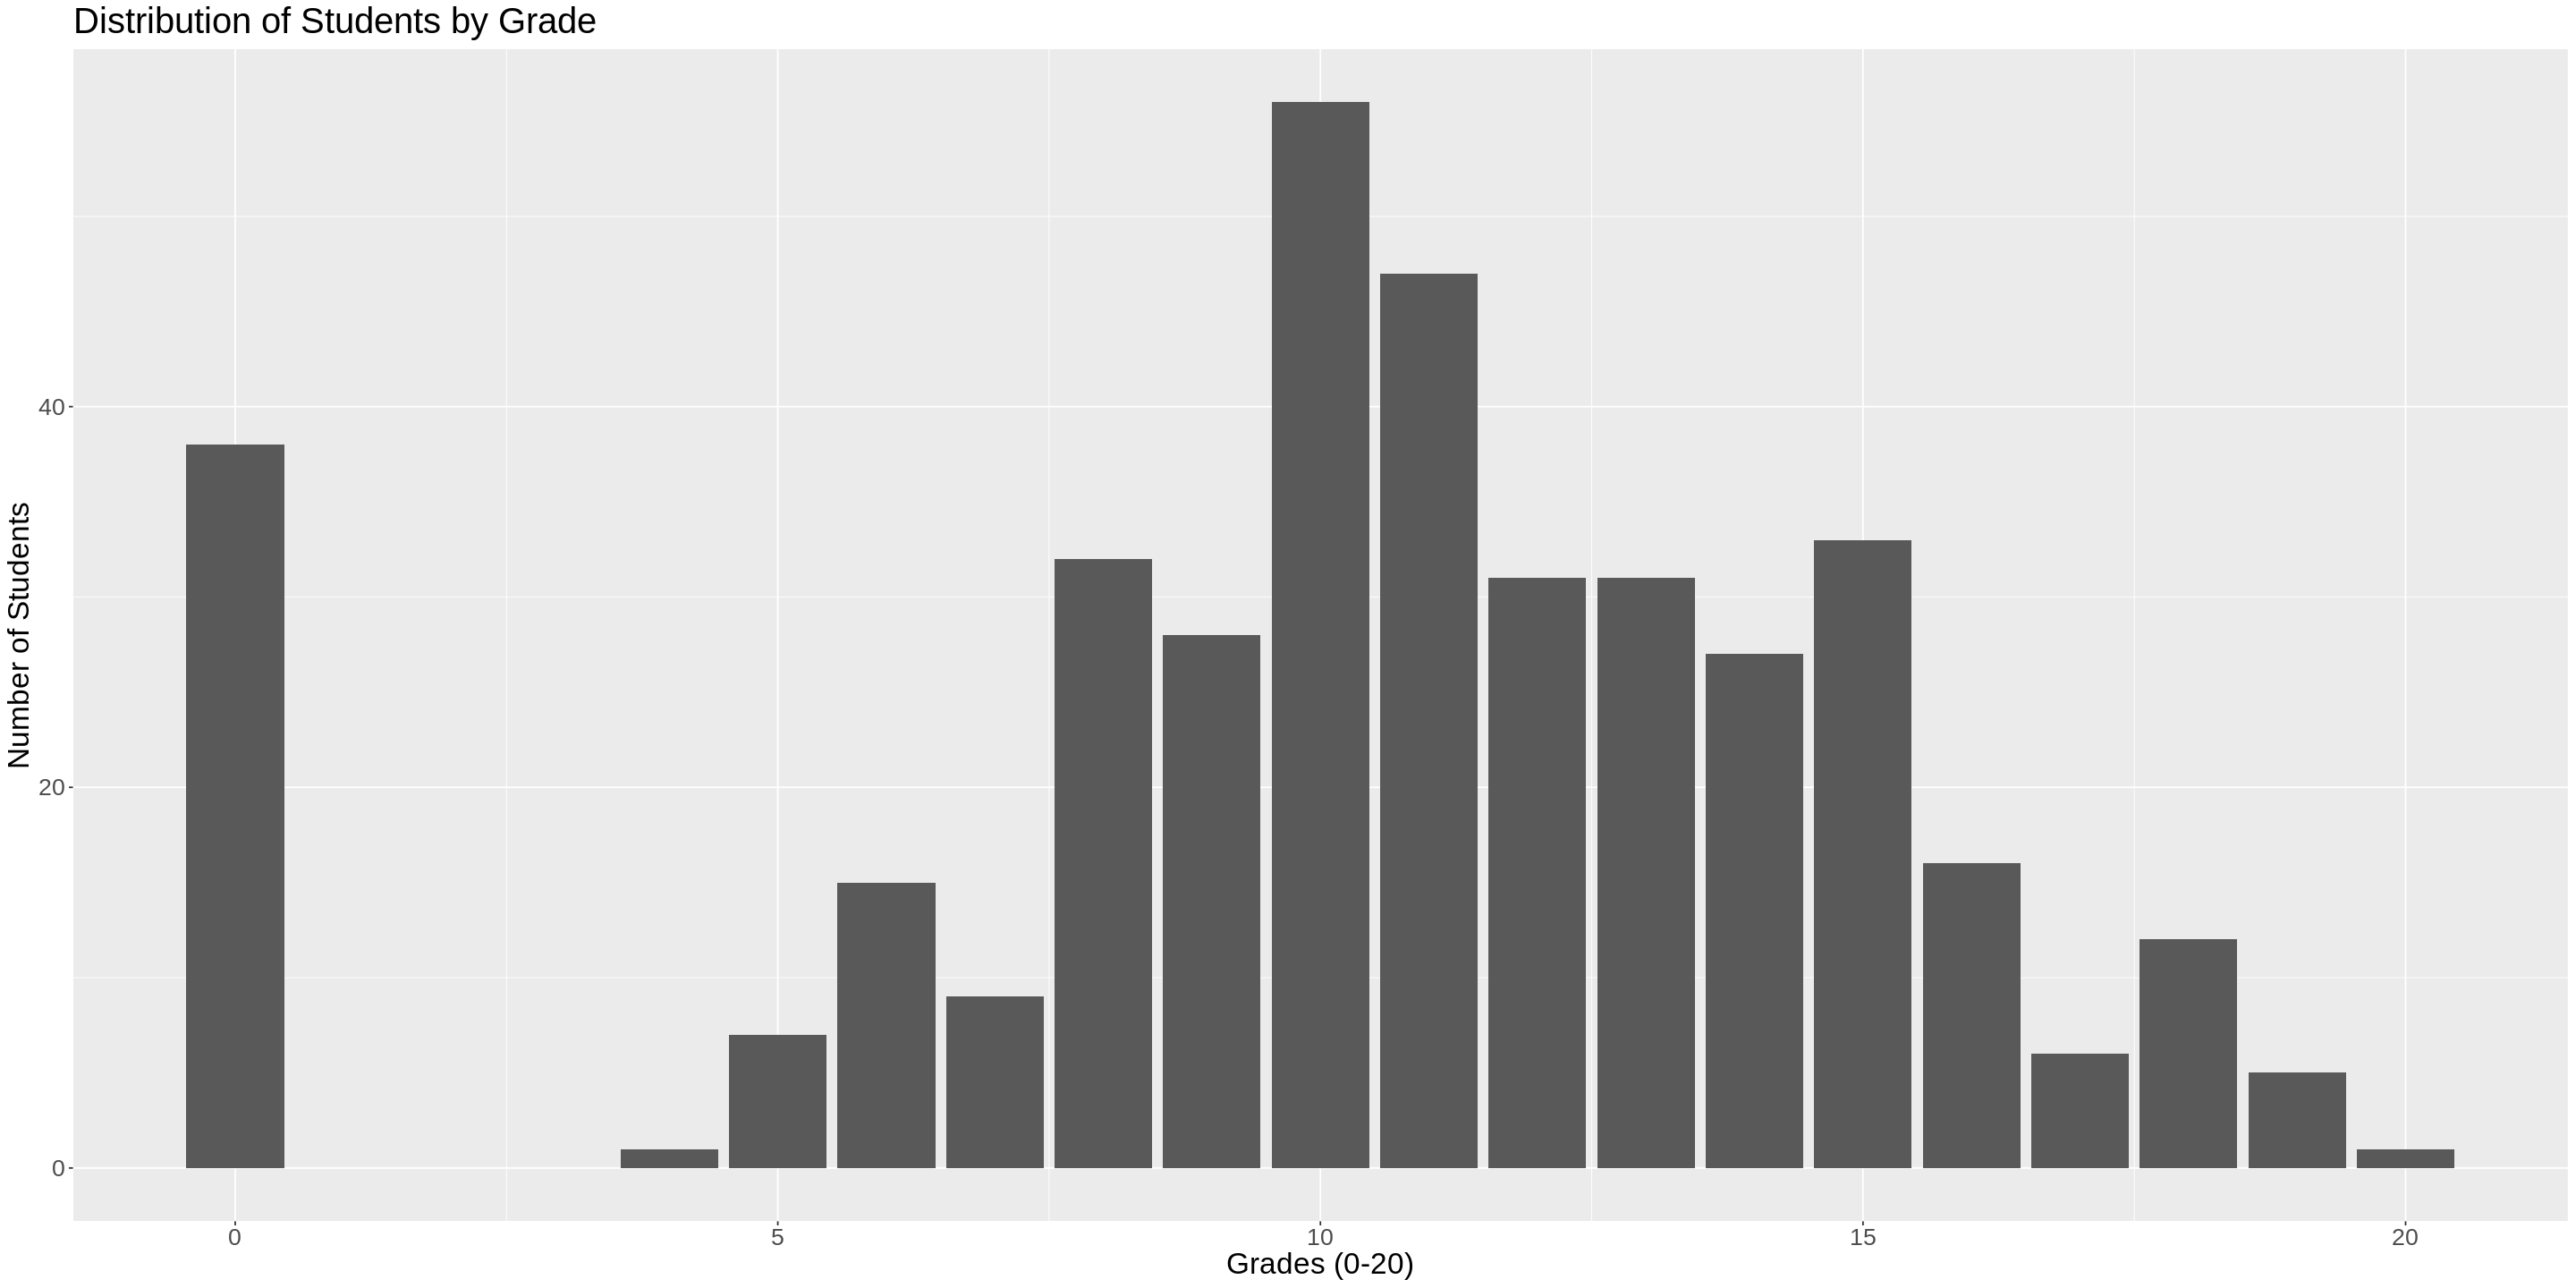

In [33]:
student_G3_count <- student_data %>%
    group_by(G3) %>%
    summarise(n = n())
# student_G3_count


student_G3_count_plot <- ggplot(student_G3_count, aes(x = G3, y = n)) +
    geom_bar(stat = "identity") +
    labs(x = "Grades (0-20)", y = "Number of Students") +
    ggtitle("Distribution of Students by Grade") +
    theme(text = element_text(size = 20))
student_G3_count_plot
        
# student_G3_count %>% arrange(n)

Figure 1: Distribution of students and their grades

In [24]:
#tidying the data
#selecting only the variables that will be most relevant
student_data_clean <- student_data %>%
    select(sex, address, Medu, Fedu, traveltime, studytime, failures, paid, activities, internet, famrel, Dalc, Walc, health, absences, G3) 
 student_data_clean_nonly <- student_data_clean %>%
     mutate(sex = ifelse(sex == "F", 1, 0), #1 is female, 0 is male
           address = ifelse(address == "U", 1, 0), #1 is Urban, 0 is Rural
           paid = ifelse(paid == "yes", 1, 0), #1 is yes, 0 is no
           activities = ifelse(activities == "yes", 1, 0), #1 is yes, 0 is no
           internet = ifelse(internet == "yes", 1, 0)) #1 is yes, 0 is no


In this cell, we commence the cleaning process of our data. Since the original data set contained 33 columns, and using 32 columns of data as predictors was certainly out of the question, for various reasons, such as the curse of dimensionality. We were able to immediately remove 17 columns which we deemed, by logic and reasoning, less important to predicting a student's grades, than the remaining ones we kept. Furthermore, we were able to remove some columns, such as column G1 and column G2, because they were a student’s grade for different periods, and we were only concerned with predicting the final grade, G3. Lastly, here is an example to illustrate our reasoning process when deleting certain students' grades. We did this by comparing one column, to another column, and the column that we deemed more valuable was kept, while the other was removed, this process was repeated numerous times. So we would compare, for example, a students age, to the amount of time a student would spend studying, and we determined that naturally, time studying, would be a significantly greater predictor, than age, however we acknowledge that there is no way to easily quantify this, this is the process we used. 


In [25]:
#Re-catergorizing data to see if model will yeild increased accuracy: 

#creating dataset and categorizing grade: 
# Note: going to play around with predictor variables to see if we can find an increased accuracy prediction 


# will denote A = Excellent, B = Meets expectations, C = needs improvement, D = terrible 

student_data_1 <- student_data_clean %>%
    select(studytime, failures, health, absences, G3)

student_data_new <- mutate(student_data_1, G3 = case_when(G3 %in% (0:4) ~ "D",
                                                       G3 %in% (5:9) ~ "C",
                                                       G3 %in% (10:14) ~ "B",
                                                       G3 %in% (15:20) ~ "A"),
                        G3 = as.factor(G3))
student_data_new


studytime,failures,health,absences,G3
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,0,3,6,C
2,0,3,4,C
2,3,3,10,B
3,0,5,2,A
2,0,5,4,B
⋮,⋮,⋮,⋮,⋮
2,2,4,11,C
1,0,2,3,A
1,3,3,3,C


Table 1: Cleaned data set with only the predictors we want as well as the grades split into 4 categories (A - D)

In this cell, we re-categorize the variable we are making predictions on, G3,  into a categorical variable with range A:D. This was done because initially, G3 consisted of integer values ranging from 0-20, which we could have technically considered as a categorical variable, where each integer value could have been considered a category. The reason we decided to re-categorize the values is because the accuracy of our predictions using 20 categories would have been very low, making the model negligible. The reason we only included four categories, D = (0:4), C = (5:9), B= (10:14), A = (15:20) is because after testing our model with different numbers of categories, we found that this range yielded us the best accuracy values by a considerable amount. Furthermore, it is important to note that we used the knn-classification model machine learning algorithm, as opposed to the regression model, since we were predicting a categorical variable, and not a numerical value.

Let's summarize the data and make some visualizations that will help us preliminarily explore our data analysis, and provide context for our discussion section.


In [27]:
student_data_count <- student_data_new %>% 
    group_by(G3) %>% 
    summarise(n = n())
student_data_count

`summarise()` ungrouping output (override with `.groups` argument)



G3,n
<fct>,<int>
A,73
B,192
C,91
D,39


Table 2: Table showing how many students have what Grade

In [30]:
#table summarizing data
student_summary<-student_data_new %>%
    select_if(is.numeric, na.rm=TRUE)%>%
    map(summary)

student_summary

number_of_rows<- nrow(student_data_new)
print(paste("rows in dataset:", as.character(number_of_rows)))

$studytime
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.035   2.000   4.000 

$failures
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3342  0.0000  3.0000 

$health
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   4.000   3.554   5.000   5.000 

$absences
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   4.000   5.709   8.000  75.000 


[1] "rows in dataset: 395"


Figure 2: Summary of predictor variables, as well as the total rows in dataset

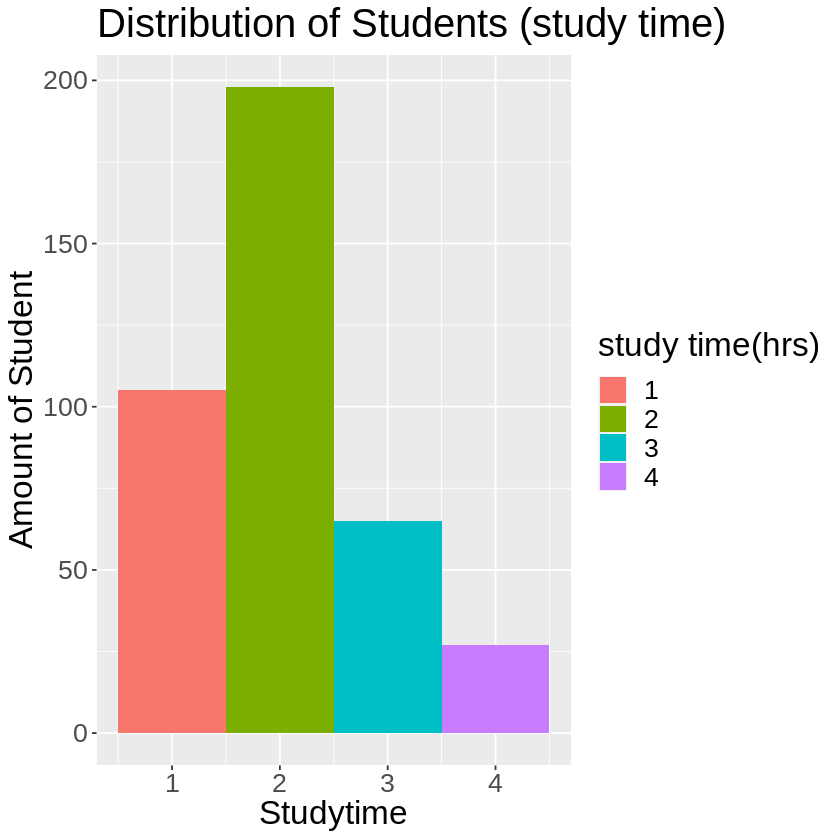

In [31]:
ggplot(student_data_new, aes(x = studytime, fill = factor(studytime))) +
    geom_histogram(binwidth = 1) +
    xlab("Studytime") +
    ylab("Amount of Student") +
    labs(fill = "study time(hrs)") +
    ggtitle("Distribution of Students (study time)") +
    theme(text = element_text(size = 20))

Figure 3.1: Distribution of students based on studytime in hours

`summarise()` regrouping output by 'studytime' (override with `.groups` argument)



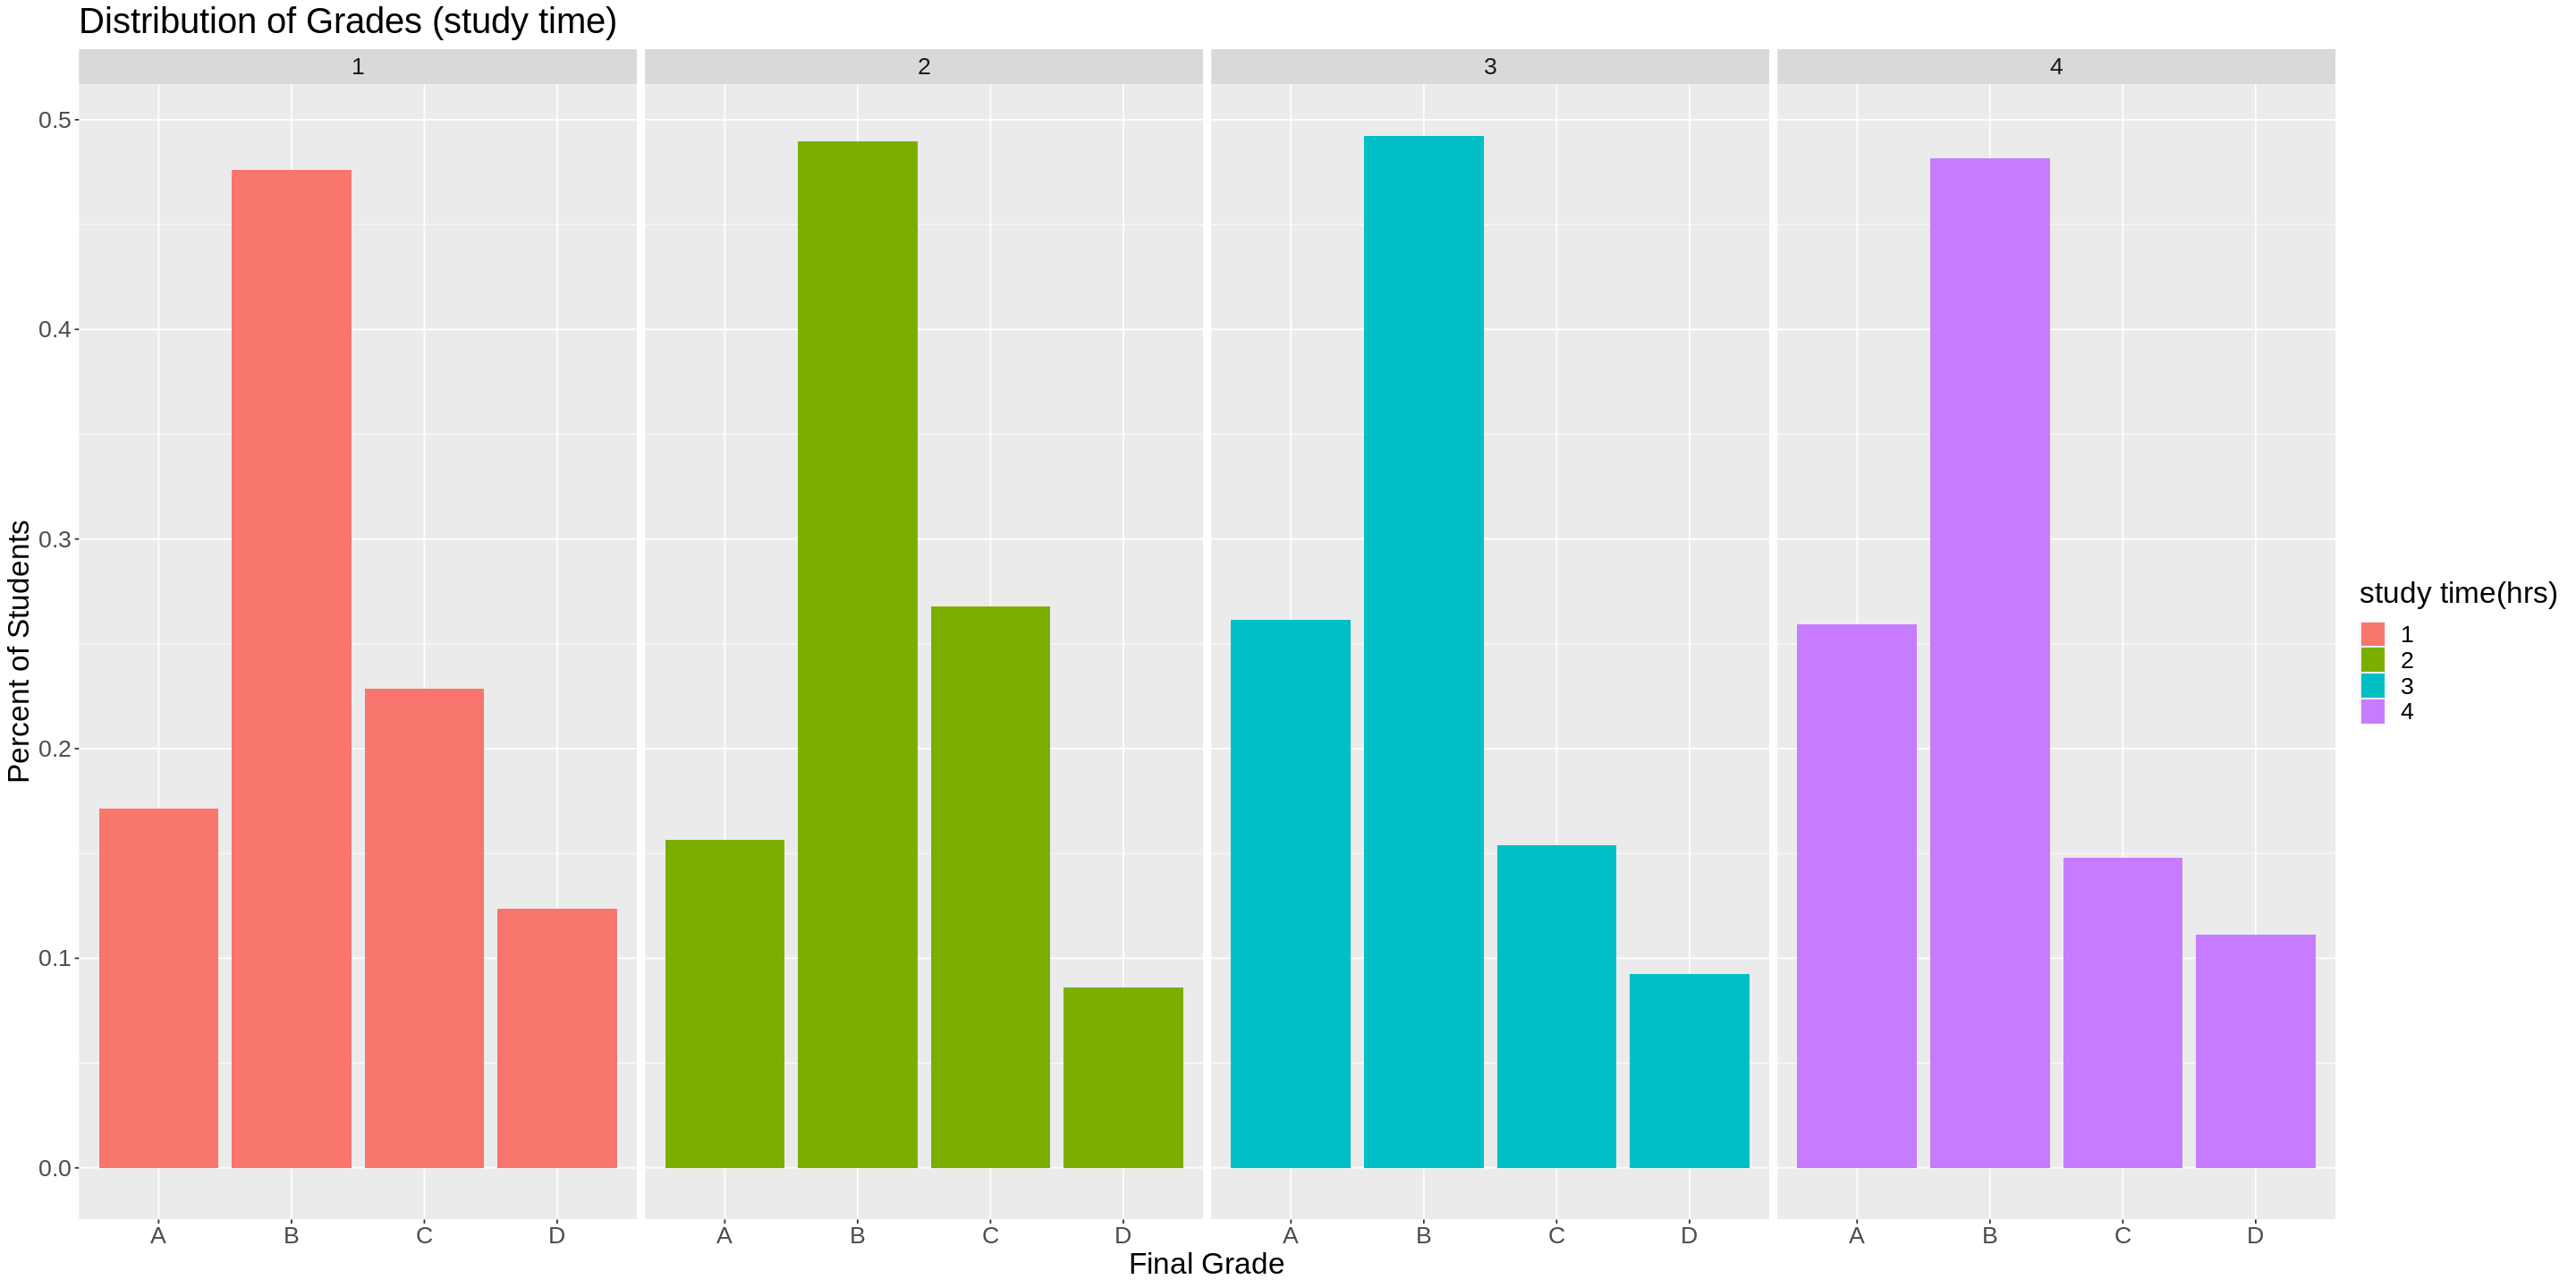

In [33]:
options(repr.plot.width = 24, repr.plot.height = 12) 

studytime_percent <- student_data_new %>%
    group_by(studytime, G3) %>%
    summarise(count = n()) %>%
    mutate(percent = count/sum(count))

# studytime_percent

ggplot(studytime_percent, aes(x = G3, y = percent, fill = factor(studytime))) +
    geom_bar(stat = "identity") +
    xlab("Final Grade") + 
    ylab("Percent of Students") + 
    labs(fill = "study time(hrs)") +
    ggtitle("Distribution of Grades (study time)") +
    theme(text = element_text(size = 20)) +
    facet_grid(.~studytime)

Figure 3.2: Distribution of grades depending on study time in hours

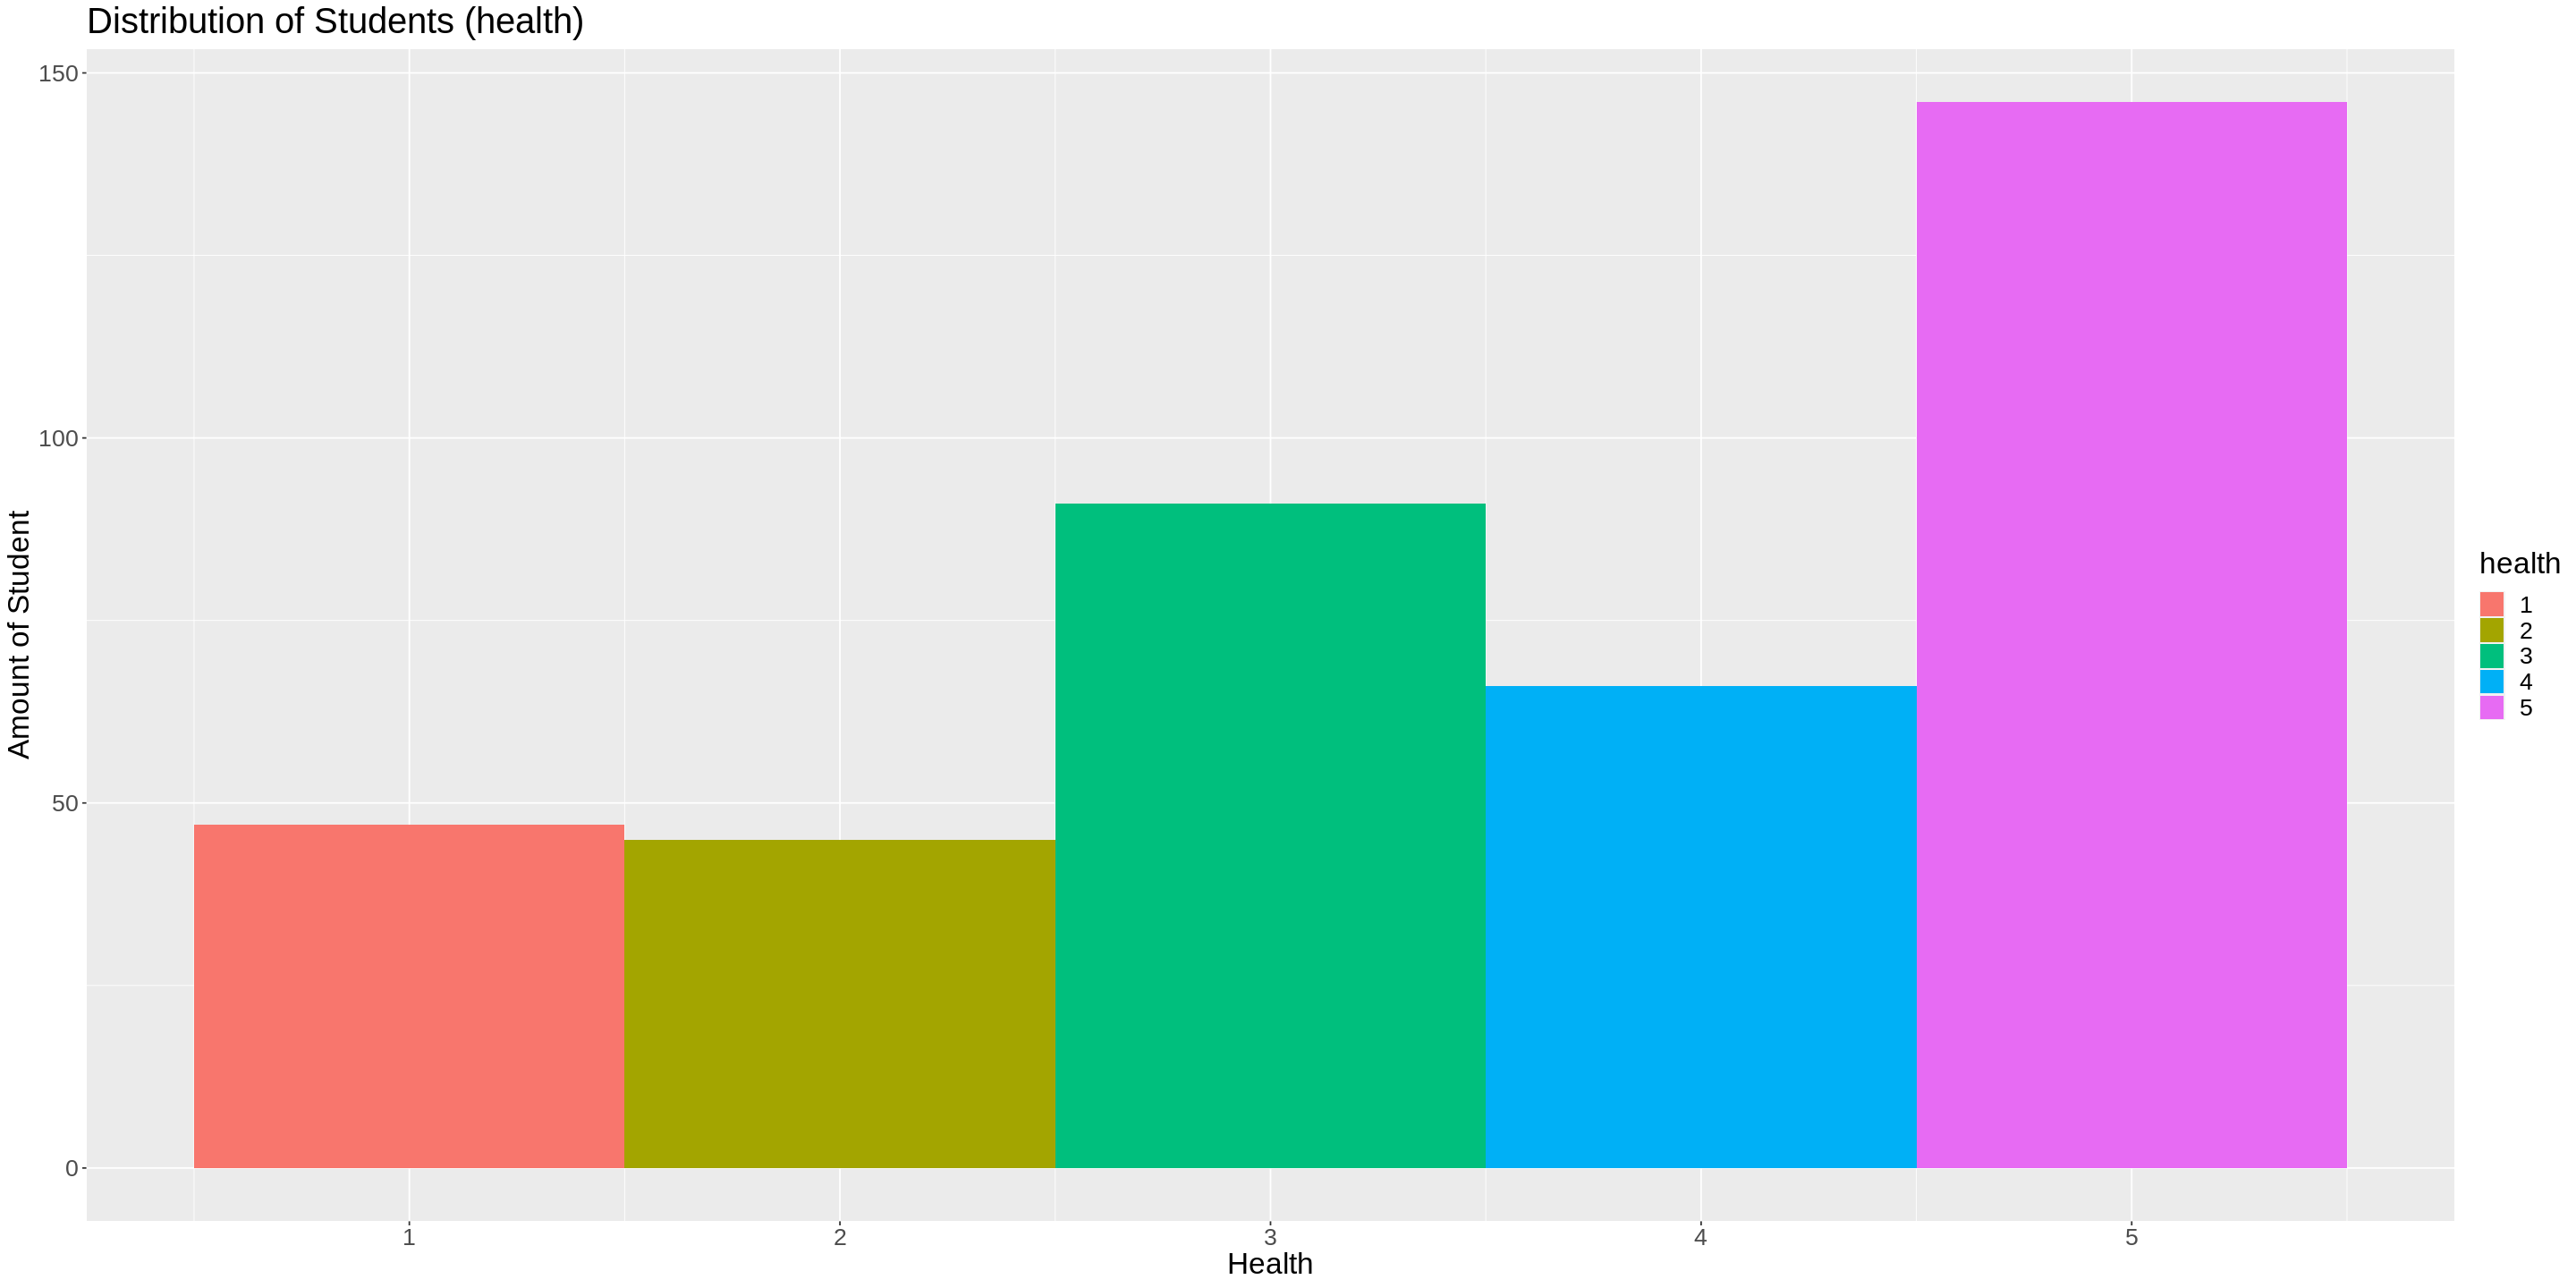

In [34]:
ggplot(student_data_new, aes(x = health, fill = factor(health))) +
    geom_histogram(binwidth = 1) +
    xlab("Health") +
    ylab("Amount of Student") +
    ggtitle("Distribution of Students (health)") +
    labs(fill = "health") +
    theme(text = element_text(size = 20))

Figure 3.3: Distribution of students based on health (1 = worst, 5 = best)

`summarise()` regrouping output by 'health' (override with `.groups` argument)



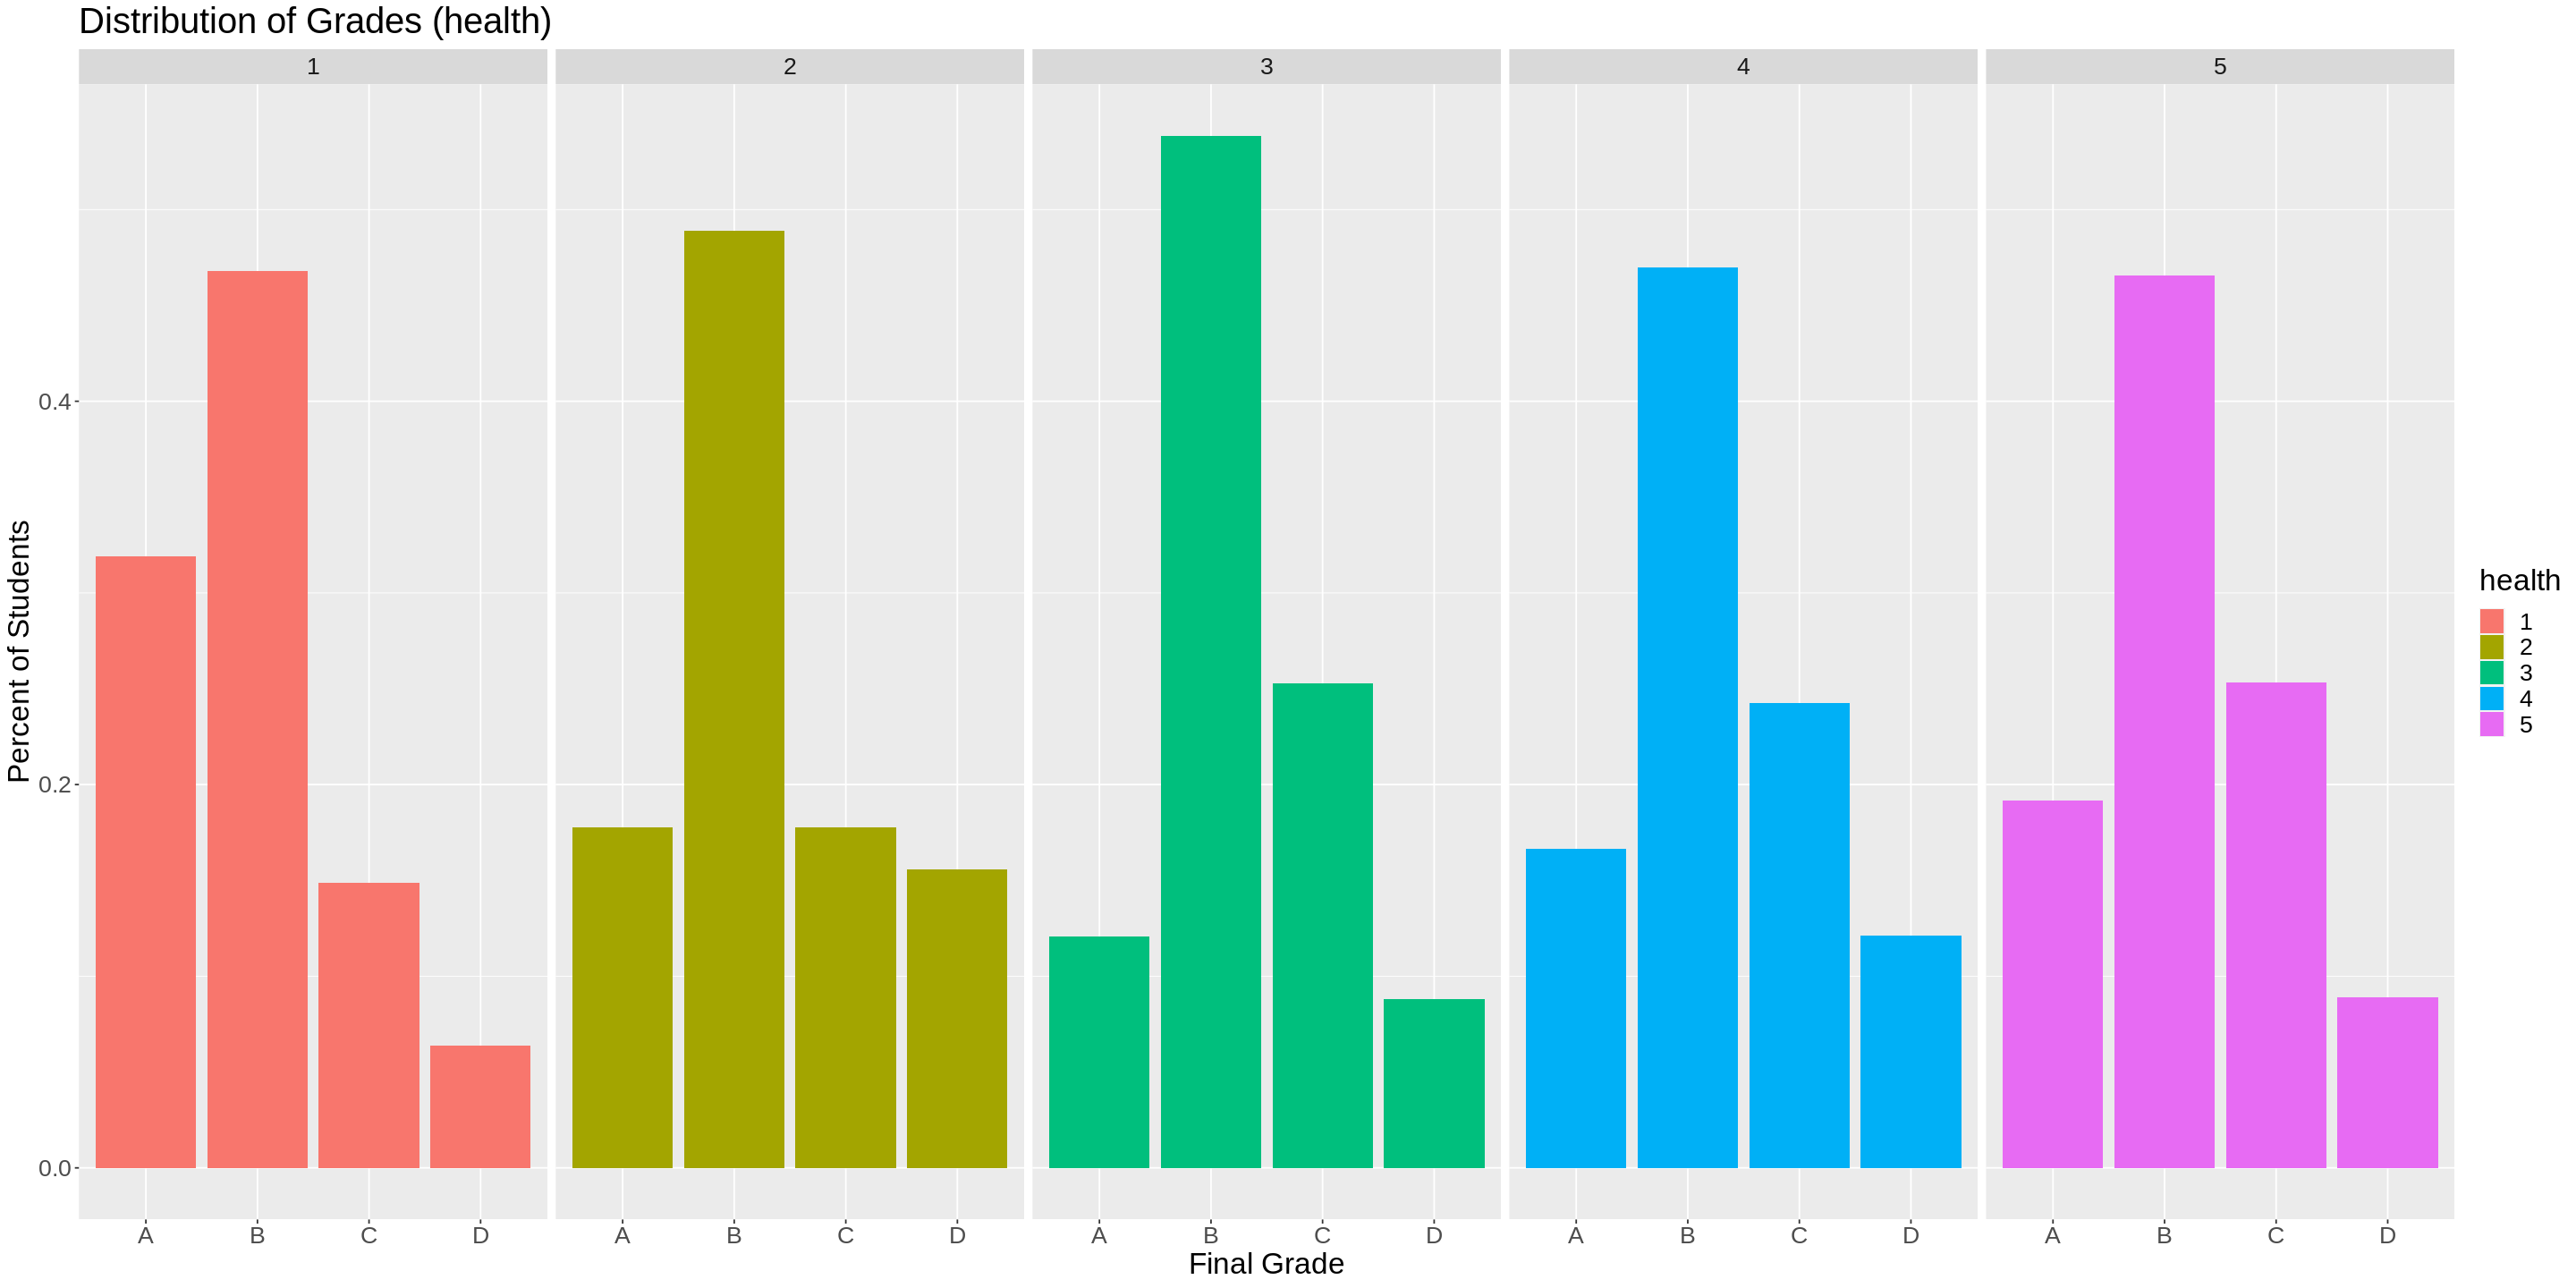

In [35]:
health_percent <- student_data_new %>%
    group_by(health, G3) %>%
    summarise(count = n()) %>%
    mutate(percent = count/sum(count))

# health_percent

ggplot(health_percent, aes(x = G3, y = percent, fill = factor(health))) +
    geom_bar(stat = "identity") +
    xlab("Final Grade") + 
    ylab("Percent of Students") + 
    labs(fill = "health") +
    ggtitle("Distribution of Grades (health)") +
    theme(text = element_text(size = 20)) +
    facet_grid(.~health)

Figure 3.4: Distribution of grades depending on health (1 = worst, 5 = best)

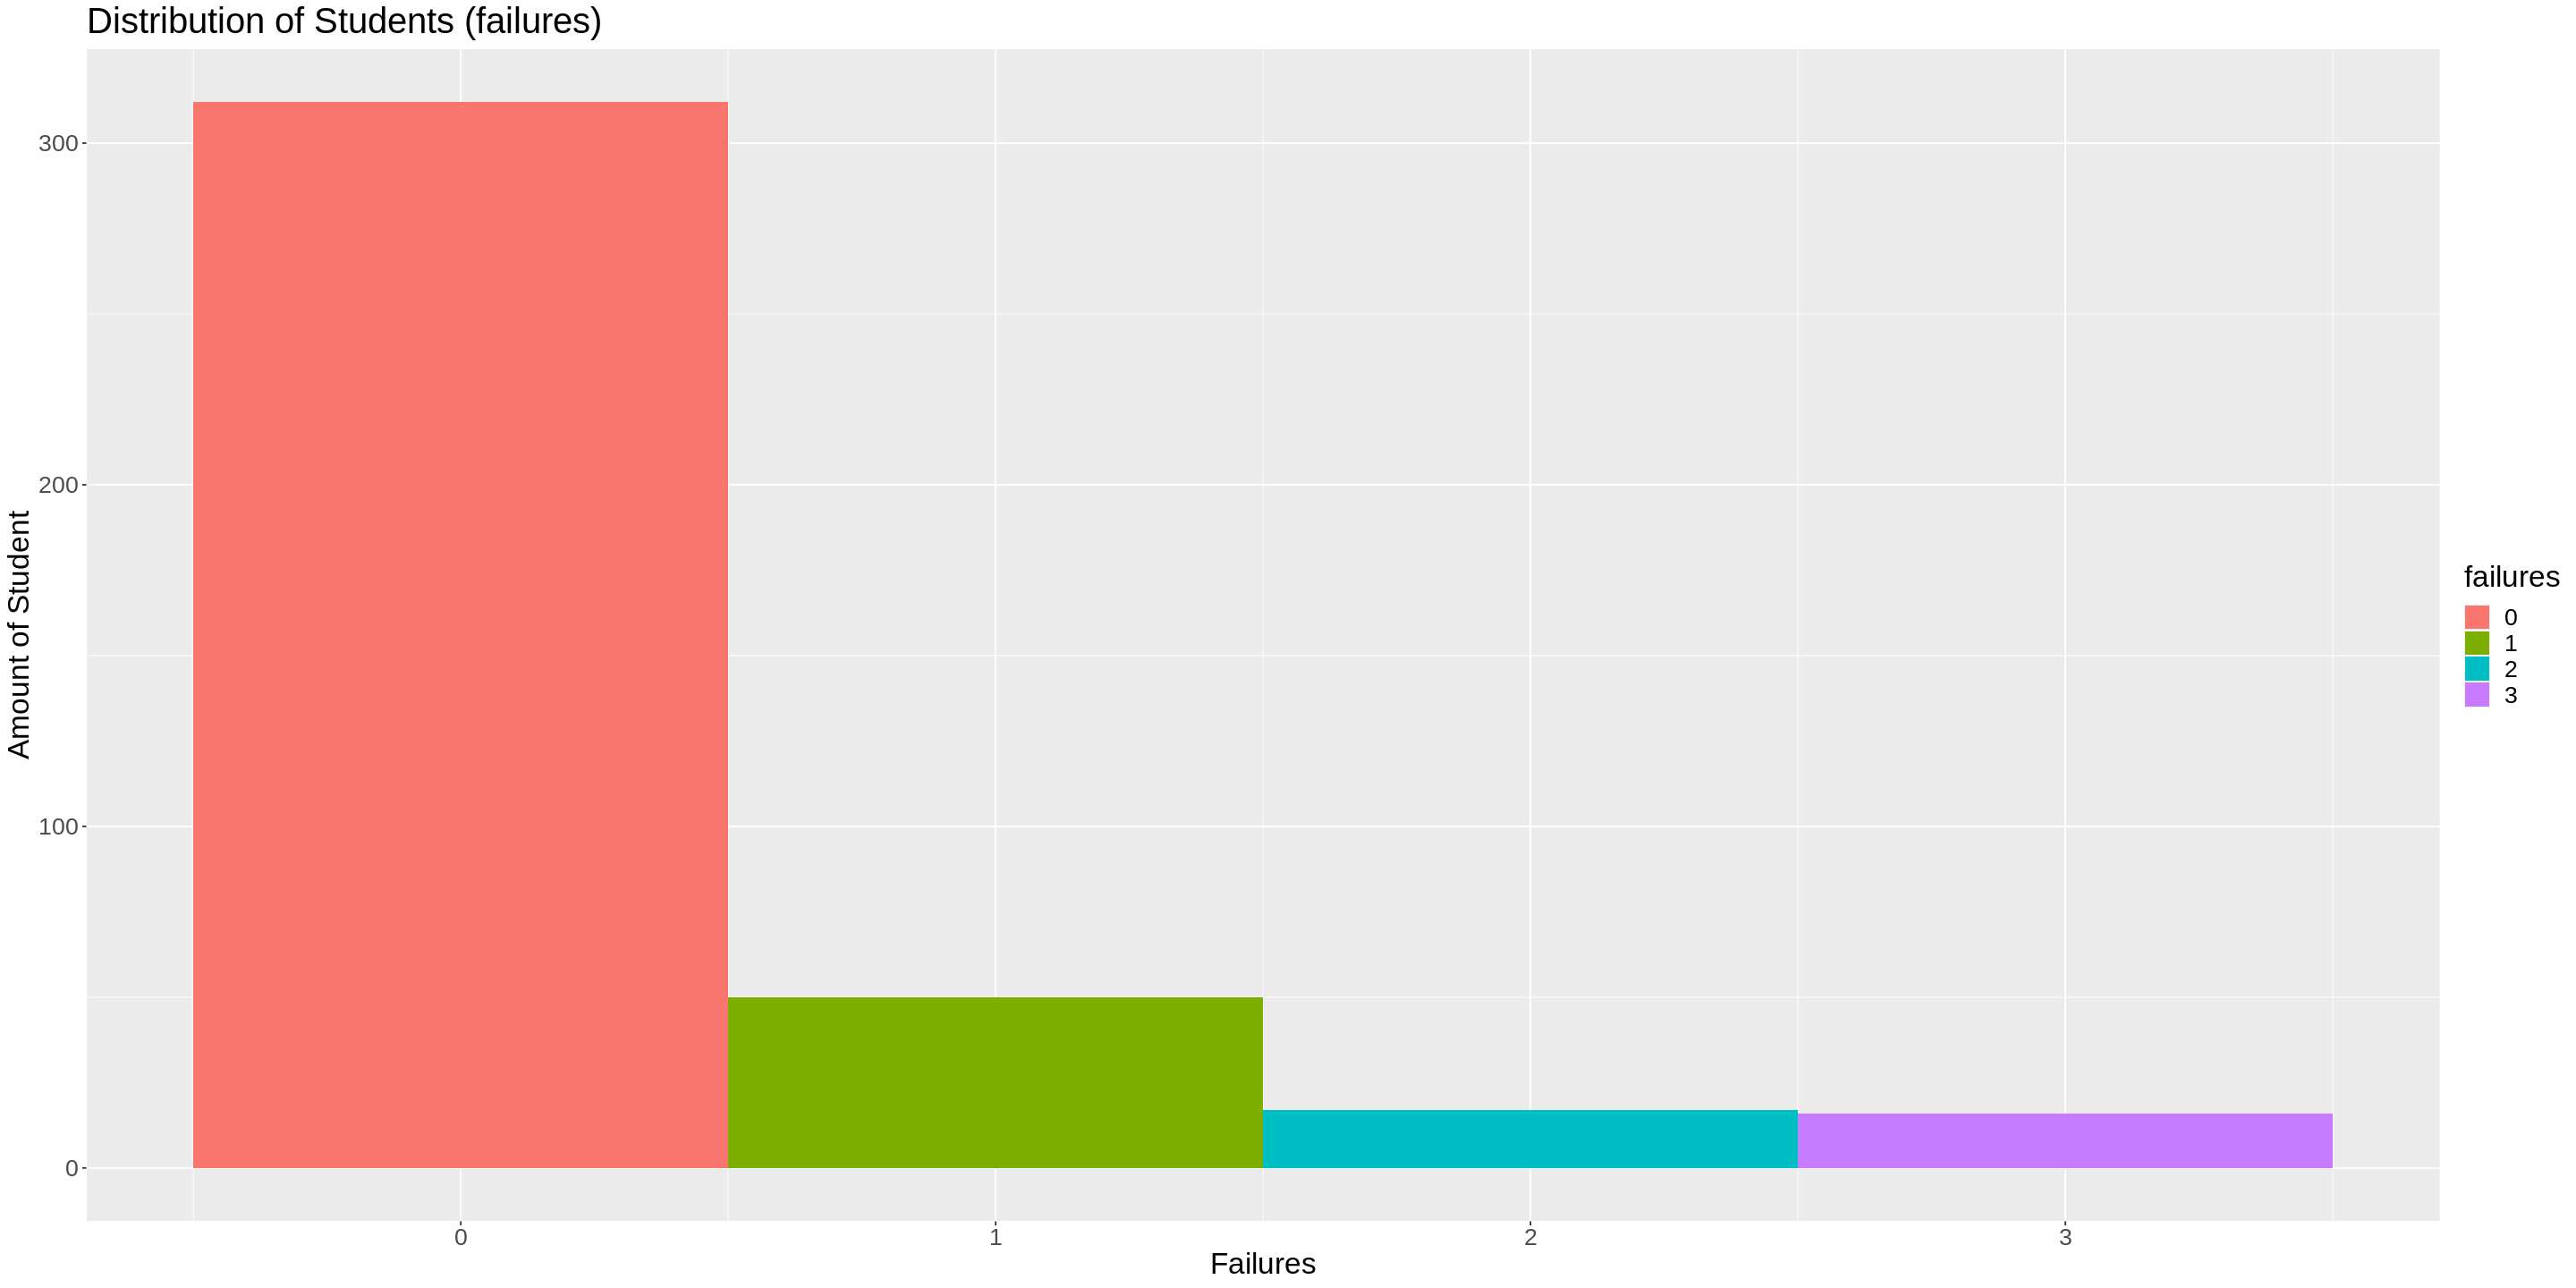

In [36]:
ggplot(student_data_new, aes(x = failures, fill = factor(failures))) +
    geom_histogram(binwidth = 1) +
    xlab("Failures") +
    ylab("Amount of Student") +
    labs(fill = "failures") +
    ggtitle("Distribution of Students (failures)") +
    theme(text = element_text(size = 20))

3.5: Distribution of students based on number of classes failed

`summarise()` regrouping output by 'failures' (override with `.groups` argument)



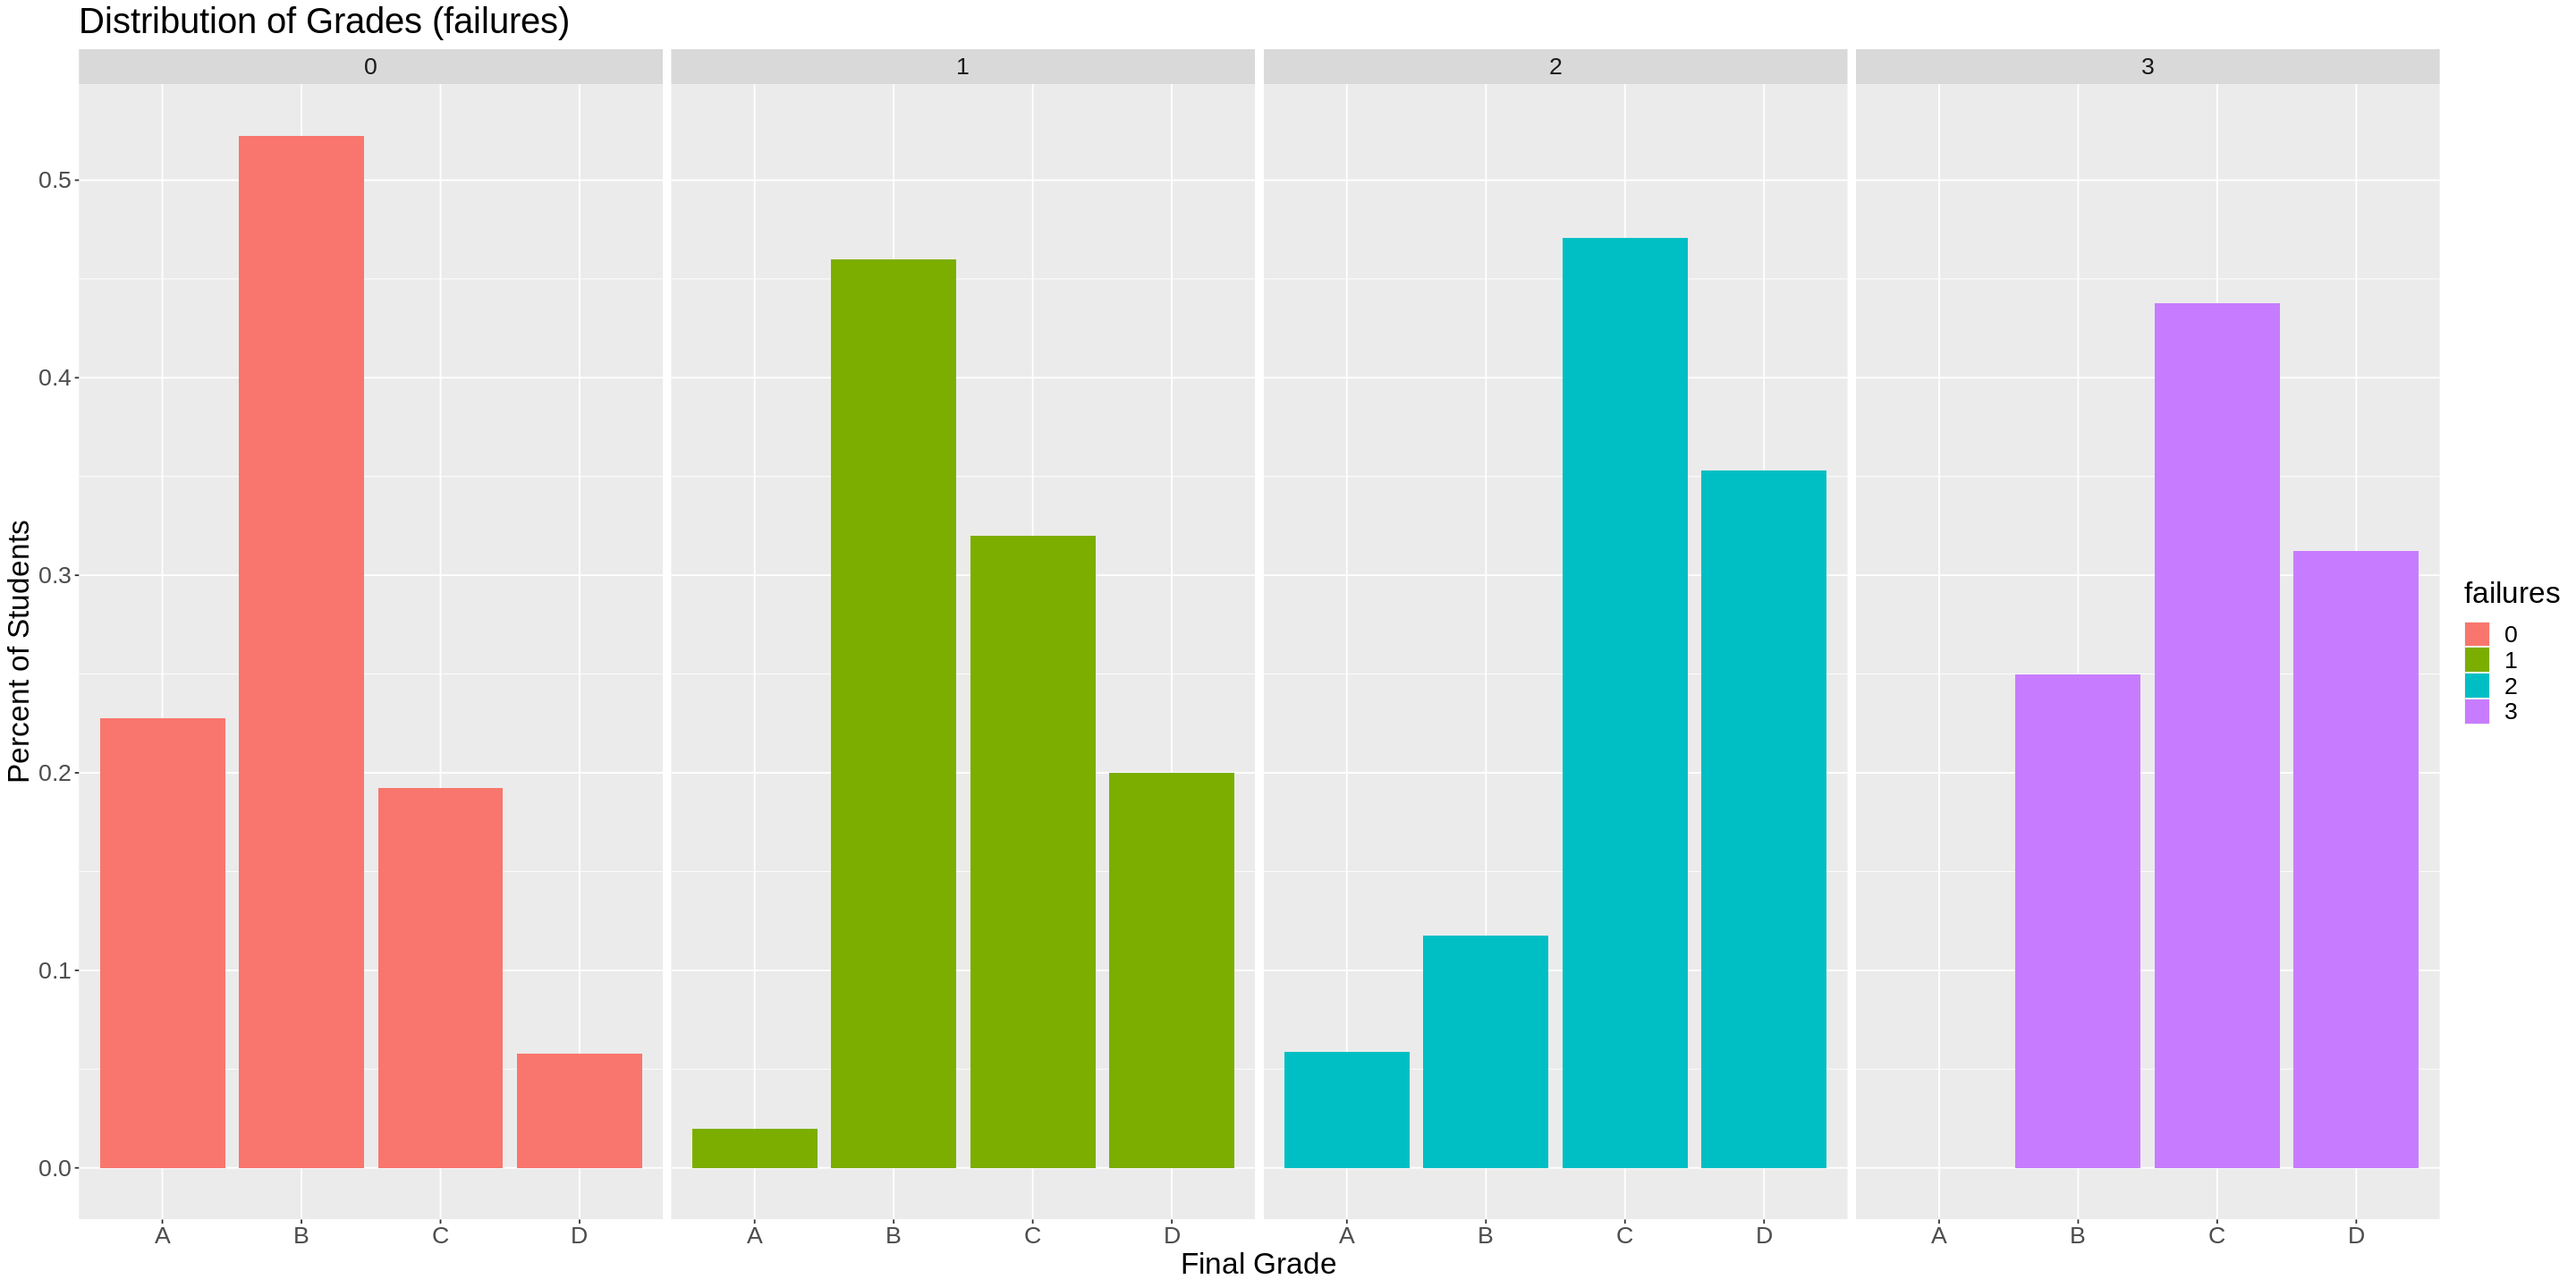

In [37]:
failures_percent <- student_data_new %>%
    group_by(failures, G3) %>%
    summarise(count = n()) %>%
    mutate(percent = count/sum(count))

# failures_percent

ggplot(failures_percent, aes(x = G3, y = percent, fill = factor(failures))) +
    geom_bar(stat = "identity") +
    xlab("Final Grade") + 
    ylab("Percent of Students") + 
    labs(fill = "failures") +
    ggtitle("Distribution of Grades (failures)") +
    theme(text = element_text(size = 20)) +
    facet_grid(.~failures)

Figure 3.6: Distribution of grades depending on classes failed

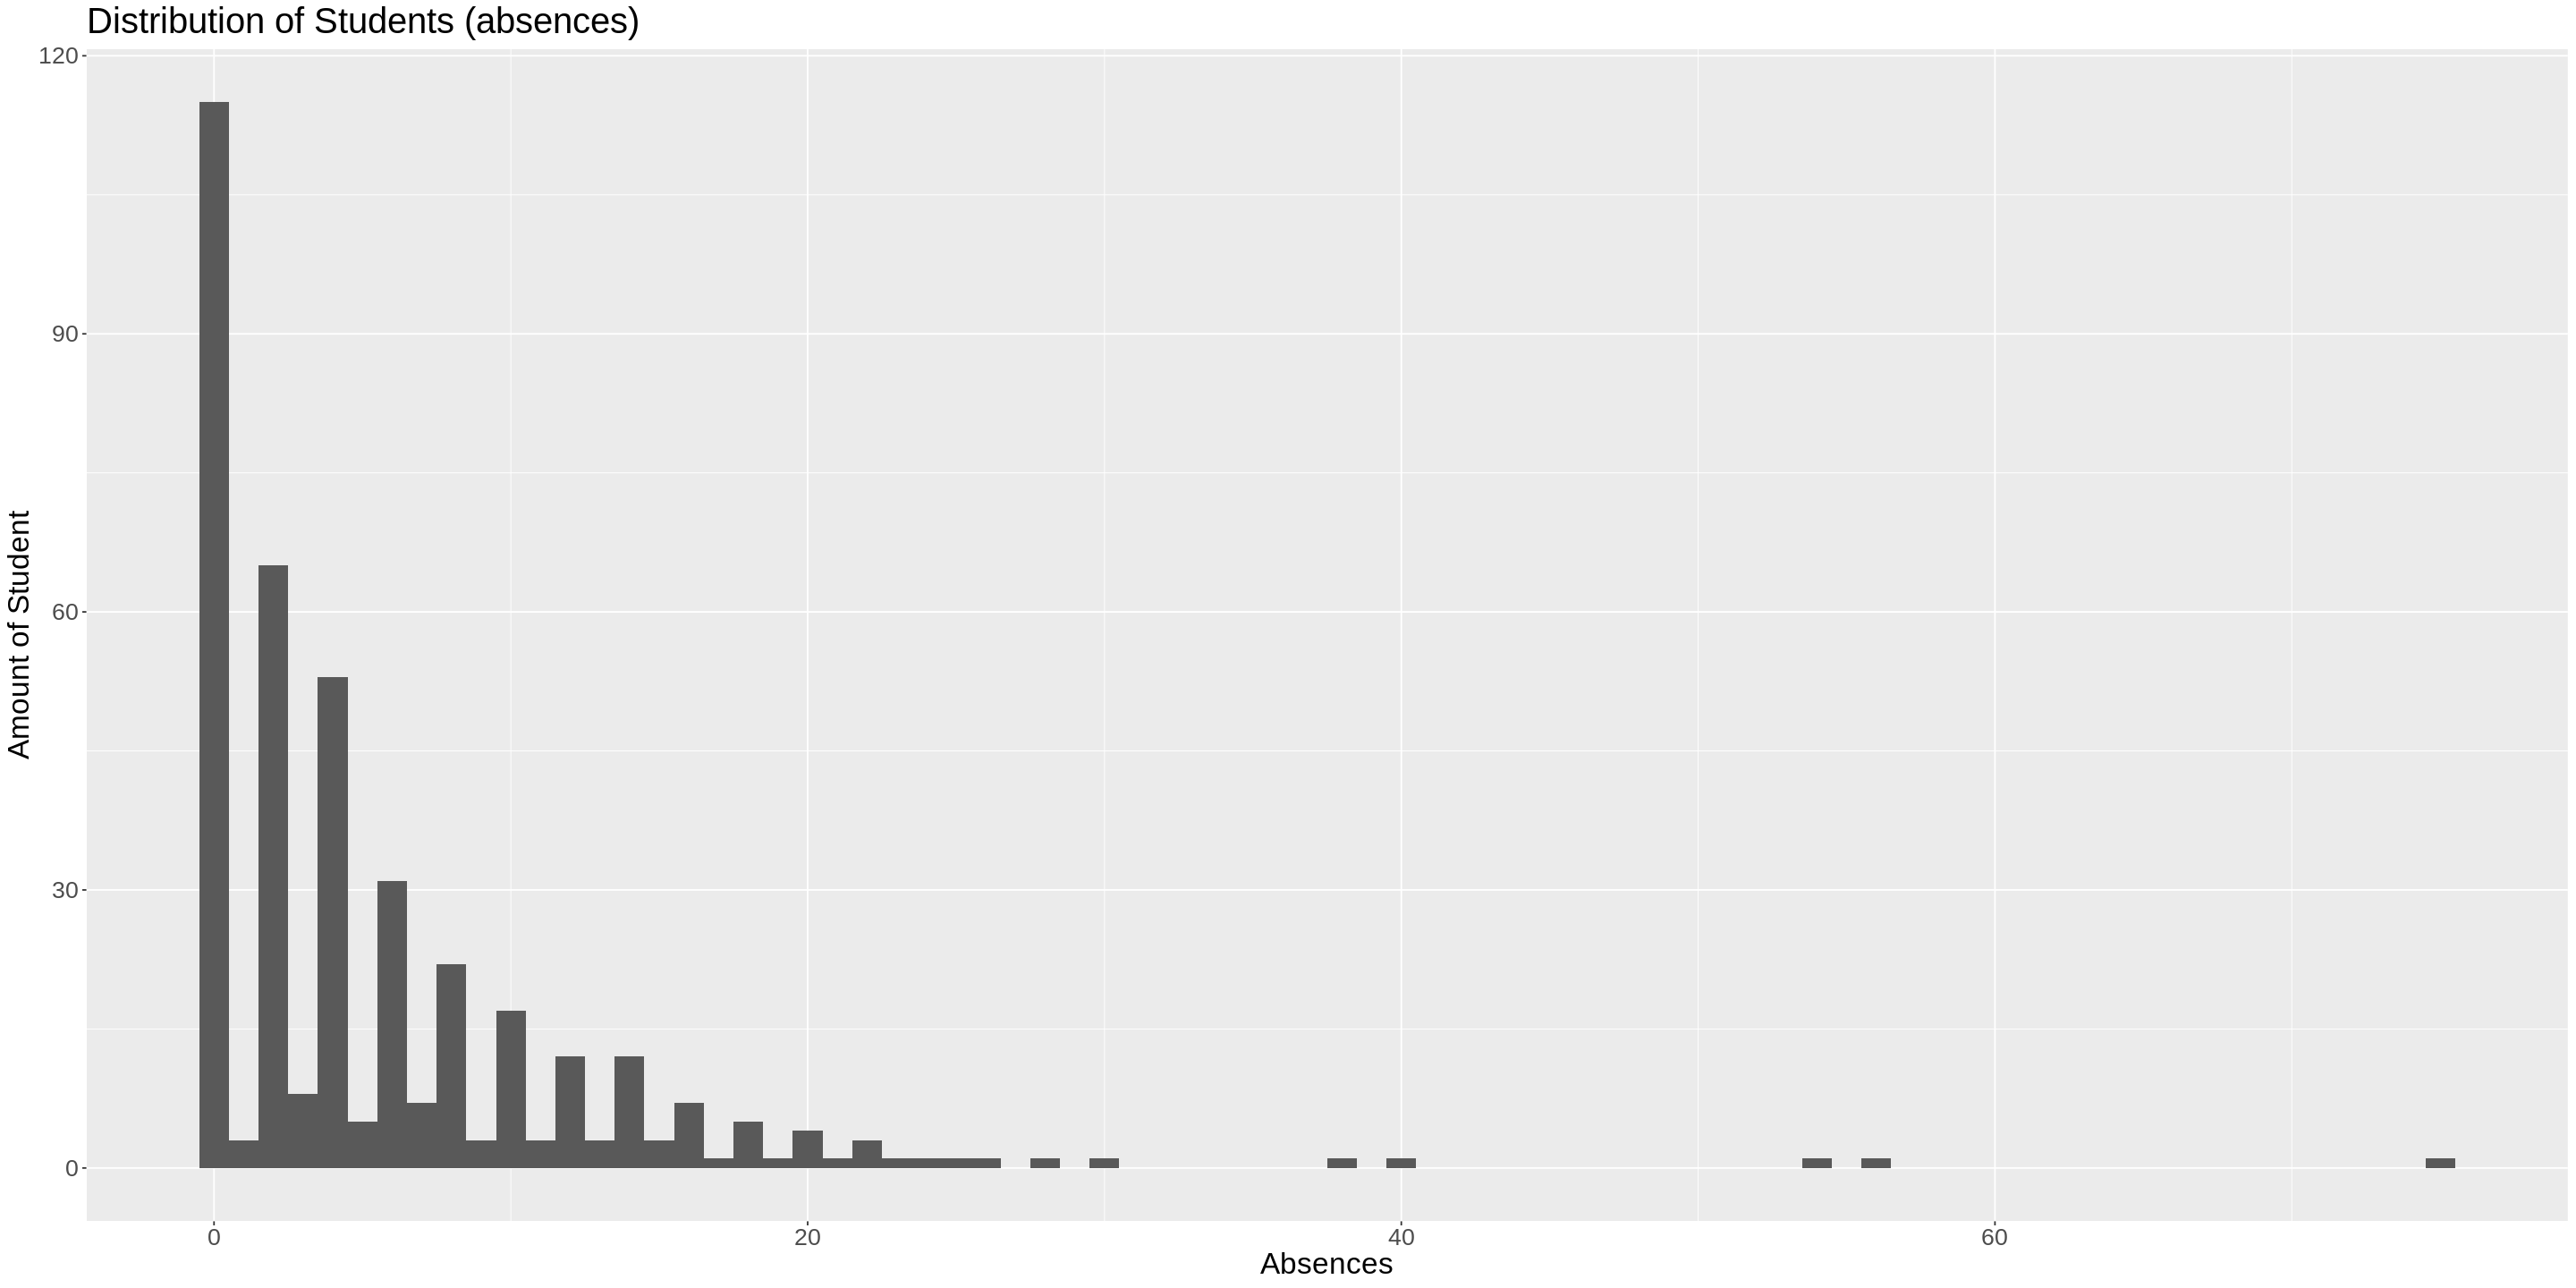

In [38]:
ggplot(student_data_new, aes(x = absences)) +
    geom_histogram(binwidth = 1) +
    xlab("Absences") +
    ylab("Amount of Student") +
    ggtitle("Distribution of Students (absences)") +
    theme(text = element_text(size = 20))

Figure 3.7: Distribution of students based on classes missed

`summarise()` regrouping output by 'absences' (override with `.groups` argument)



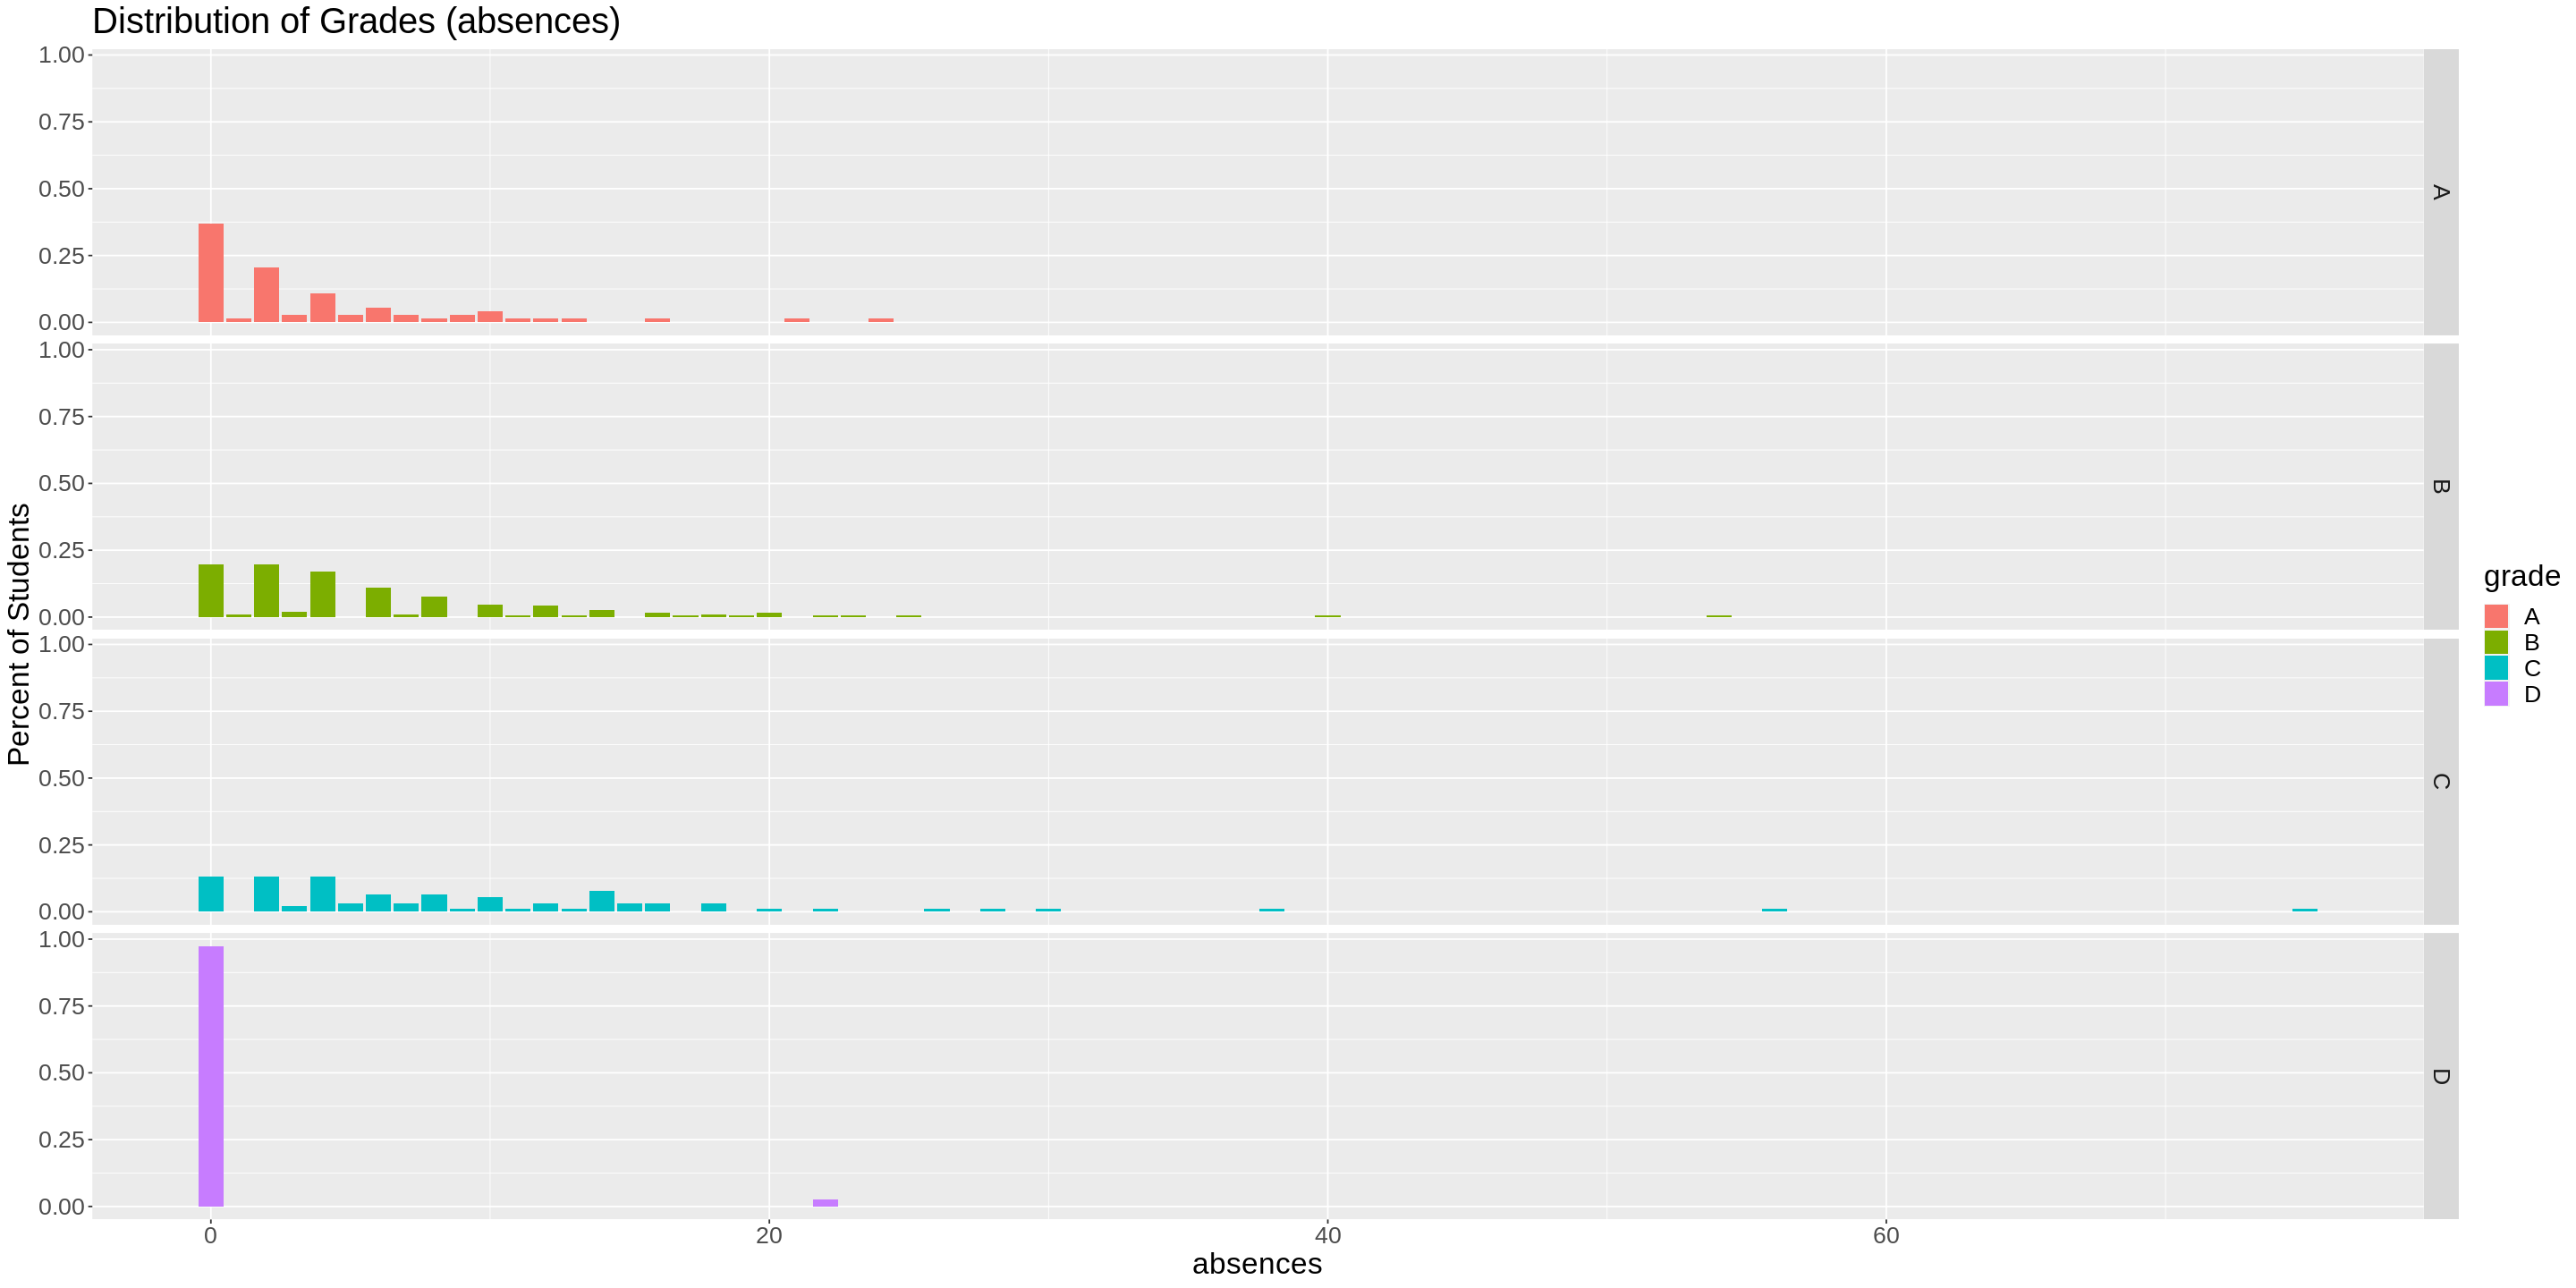

In [39]:
absences_percent <- student_data_new %>% 
    group_by(absences, G3) %>% 
    summarise(count = n()) %>%
    group_by(G3) %>%
    mutate(percent = count/sum(count))

ggplot(absences_percent, aes(x = absences, y = percent, fill = factor(G3))) +
    geom_bar(stat = "identity") +
    xlab("absences") + 
    ylab("Percent of Students") + 
    labs(fill = "grade") +
    ggtitle("Distribution of Grades (absences)") +
    theme(text = element_text(size = 20)) +
    facet_grid(G3~.)


Figure 3.8: Distribution of percent of students based on classes missed, separated by grade

The first 3 graphs are distribution of percentage of students, split up over the different classes the variable we're looking at.

For example, in the topmost graph, it is split between daily hours of study, we see that out of those students with 1 or 2 hours of study, a lower percent got A when compared to the students with 3 or 4 hours.

The graph with absences is done differently, because absences have many different values, thus using the same strategy for the first 3 graphs wouldn't have worked. What we did instead is that we split up the students by grade instead. We see that out of all A students, a high percent of them had zero absences when compared to students with B or C.   
**Note: Discussion of all visualizations will be elaborated on in the Discussion Section.**

***This concludes our preliminary analysis. Now we'll move onto the data analysis.***

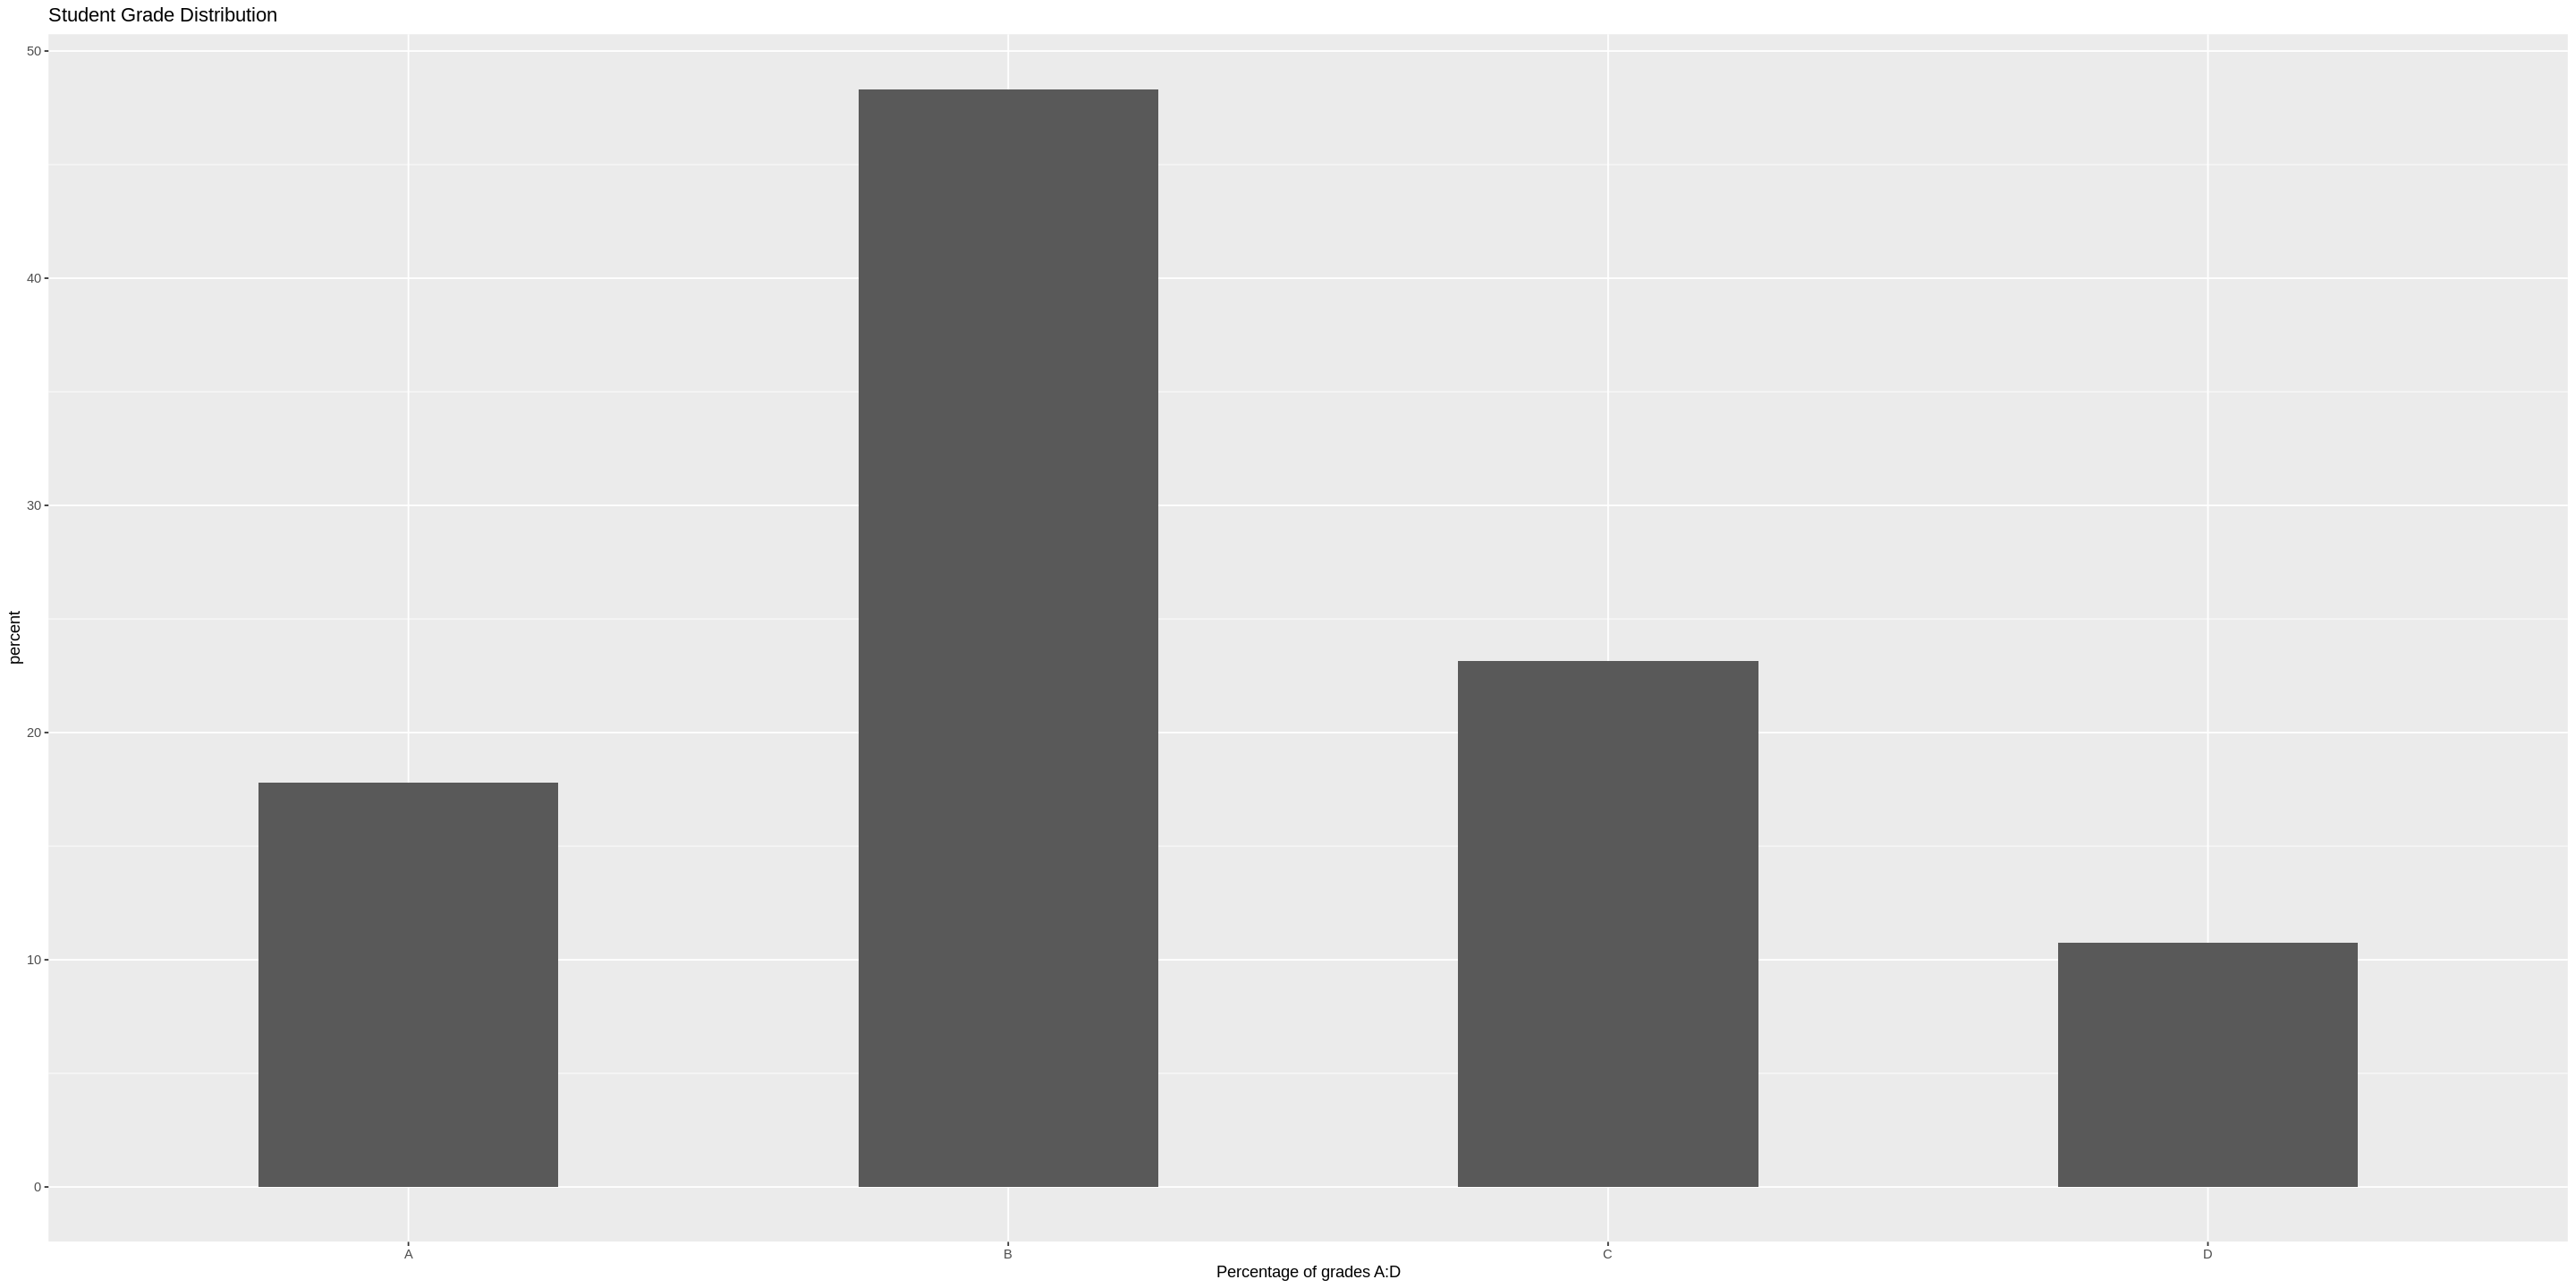

In [46]:
# I will split data 
set.seed(2000)


#split data (choosing )
student_data_split<-initial_split(student_data_new, prop = 0.75, strata=G3)
student_data_train <- training(student_data_split)
student_data_test<- testing(student_data_split)


# split data into training and testing so we can optimize knn-classfication model

# split into 5 sub section to preform cross validation
student_data_vfold<-vfold_cv(student_data_train, v = 5, strata = G3)

# below is a distribution of grades by catergory A:D, just to show the relative distribution. As we can see below, 
#our bar chart follows a relatively normal distribution, and is skewed slightly to the right. 
student_grade_dist_plot<- student_grade_distribution%>%
    ggplot(aes(x = G3, y= percent))+
    geom_bar(stat="identity", width=0.5)+
    labs(x= "Percentage of grades A:D")+
    ggtitle("Student Grade Distribution")
student_grade_dist_plot


Figure 3.9: Distribution of grades across all observations

In this cell, we initially use the set.seed function in order to make our model reproducible, which is a critical tenet in data analysis. This is followed by splitting our cleaned data, into a training, and test set, we decided to split our data to be 75% data contained in the training set, and 25% of the data contained in the testing set, while we specified G3 to be stratified so that roughly equal proportions of  G3’s classes would be in both test and training sets. We manually tested different test/training split values, ranging from the training set being 50% of the data, to 90%, and found that the 75/25 split yielded the best results. We have decided to exclude these test cases as we deemed it not necessary to show, due to redundancy, however, we have decided to mention our findings in order to support the decision of choosing these split proportions. 



In [53]:
#next we are going to standardize the data: this is important to do since we want each predictor variable to be on a
#common scale, without distorting/changing the difference in the range of values. In this case, we are only going to standardize 
#the training data:
set.seed(1234)

recipe_student_data<-recipe(G3 ~studytime +failures +health + absences, data = student_data_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

recipe_student_data

#make classifier: 

knn_student_data<- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

knn_student_data

# fit model

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 3))

student_knn_fit <- workflow()%>%
    add_recipe(recipe_student_data)%>%
    add_model(knn_student_data)%>%
    tune_grid(resamples = student_data_vfold, grid = k_vals)%>%
    collect_metrics()
student_knn_fit


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4731791,5,0.04966285,Model01
1,roc_auc,hand_till,0.6200180,5,0.02643928,Model01
4,accuracy,multiclass,0.4949257,5,0.04589769,Model02
4,roc_auc,hand_till,0.6738726,5,0.04588019,Model02
7,accuracy,multiclass,0.4808419,5,0.03898986,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
34,roc_auc,hand_till,0.6660946,5,0.03683380,Model12
37,accuracy,multiclass,0.5106854,5,0.02148063,Model13
37,roc_auc,hand_till,0.6746341,5,0.03973482,Model13


Table 3: Summary of metrics

In order to find a k value  that optimizes or models performance, we implemented the use of cross validation. This allowed us to identify a k value that would maximize accuracy, while not being too large, or too small, in order to minimize the chance of overfitting or underfitting our data. The decision to separate our data into 5 validation sets (v = 5) was made because it maximized our models accuracy, using, what we deemed, an optimal k-value (what we define as an optimal k-value will be discussed below) and yielded similar standard error values of v =10 (but with increased accuracy, and better k-value). 

It is important to note that we ran test using a variety of validation set sizes, we have again decided to exclude our code, due to extensive run time and redundancy, but examples of what we found are provided below: 

When using 10 and 15 validation sets, we found the accuracy of our model on our training data to be ~ 52%, found with k-values ranging from 14-20. 
When using a 3 validation sets, we found our accuracy to again be ~ 50-52%, but this time with k-values ranging from 30+ (which would lead to underfitting) due to our test set consisting of 100 observations. 
When using a significantly higher number of validation sets, such as 100, the prediction accuracy (on our training data) increased to 60%, which, as expected, was the best we had seen. However, due to computational limitations (such as extensive run time), we decided that it would be feasible to use this. 

As such, we used v = 5, which yielded an accuracy of 54 %, which was ascertained using k =13. 


In the code cell which is above the markdown cell above, we created a recipe for our filtered  student data, using the training set,  which contains the target variable G3, and the four predictor variables we chose, on top of this, we centered and scaled this data. This was done to ensure that each of the predictor variables are on a uniform scale, since when using our knn-classification model we use the straight line distance to the nearest neighbors, so if one predictor has a significantly larger range of values than, it would have a larger influence (far greater or lesser distance) on the model. Meaning the predictions could be overly influenced by certain predictors, which is an issue, that is why we want each predictor to be on a common scale. 

The decision to choose the predictor variables that we did was an arduous topic that utilized published research and trial and error. We identified that the relationship between classroom attendance and spent studying were strongly positively correlated with student academic success (Zulauf & Gortner, 1999). As students, understanding how study time and missing class is incredibly important and tangible to becoming a stronger, more well rounded student, and thus we decided to choose these two to test how well the combination of them would predict a students grade. In hopes of identifying ways in which we, as students, could improve, and to show and demonstrate to educators the importance of these factors. The final two predictors, health and failures, were chosen through a trial and error process (testing our model with different combinations of predictors) that allowed us to minimize the number of predictors and maximize the predictor accuracy. The code showing this process has been primarily excluded, due to redundancy, however at the bottom of the analysis section, we have included an example to illustrate how we did this. 

The next function, knn_student_data, builds our classifier, specifying neighbors = tune(), allowing us to identify the optimal k value that we will use later when applying our model to the test data.


Then, we created a tibble of k values, which will allow us to find the optimal k value once we fit our model with the training set. We chose a range from k= 1- 40, because going too much above this will result in the code taking a long time to compute, due to the amount of additional calculations needed, additionally, we did try k values 50 and above and found that the best k-value was never that high anyways.
Then we created the fitted model, called student_knn_fit, that implements the validation sets, and the range of k values, in order to see which k values yielded the greatest accuracy, while keeping k in a good range, in order to make the most accurate predictions on our test data. 


In [54]:
#Finding accuracy of model
accuracy_student_data<- student_knn_fit%>%
    filter(.metric == "accuracy")%>%
    arrange(desc(mean))
best_k<- accuracy_student_data%>%
    slice(1)
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,multiclass,0.541389,5,0.03320808,Model05


Table 3.1: K-value that gives us the best accuracy estimate

The purpose of this cell was to identify the k value that yielded the highest accuracy on the training data, which is shown to be an accuracy of ~ 54 % at a k value of 13. Now that we have ascertained this data, we will use k=13 when predicting G3 categories on the test set. 


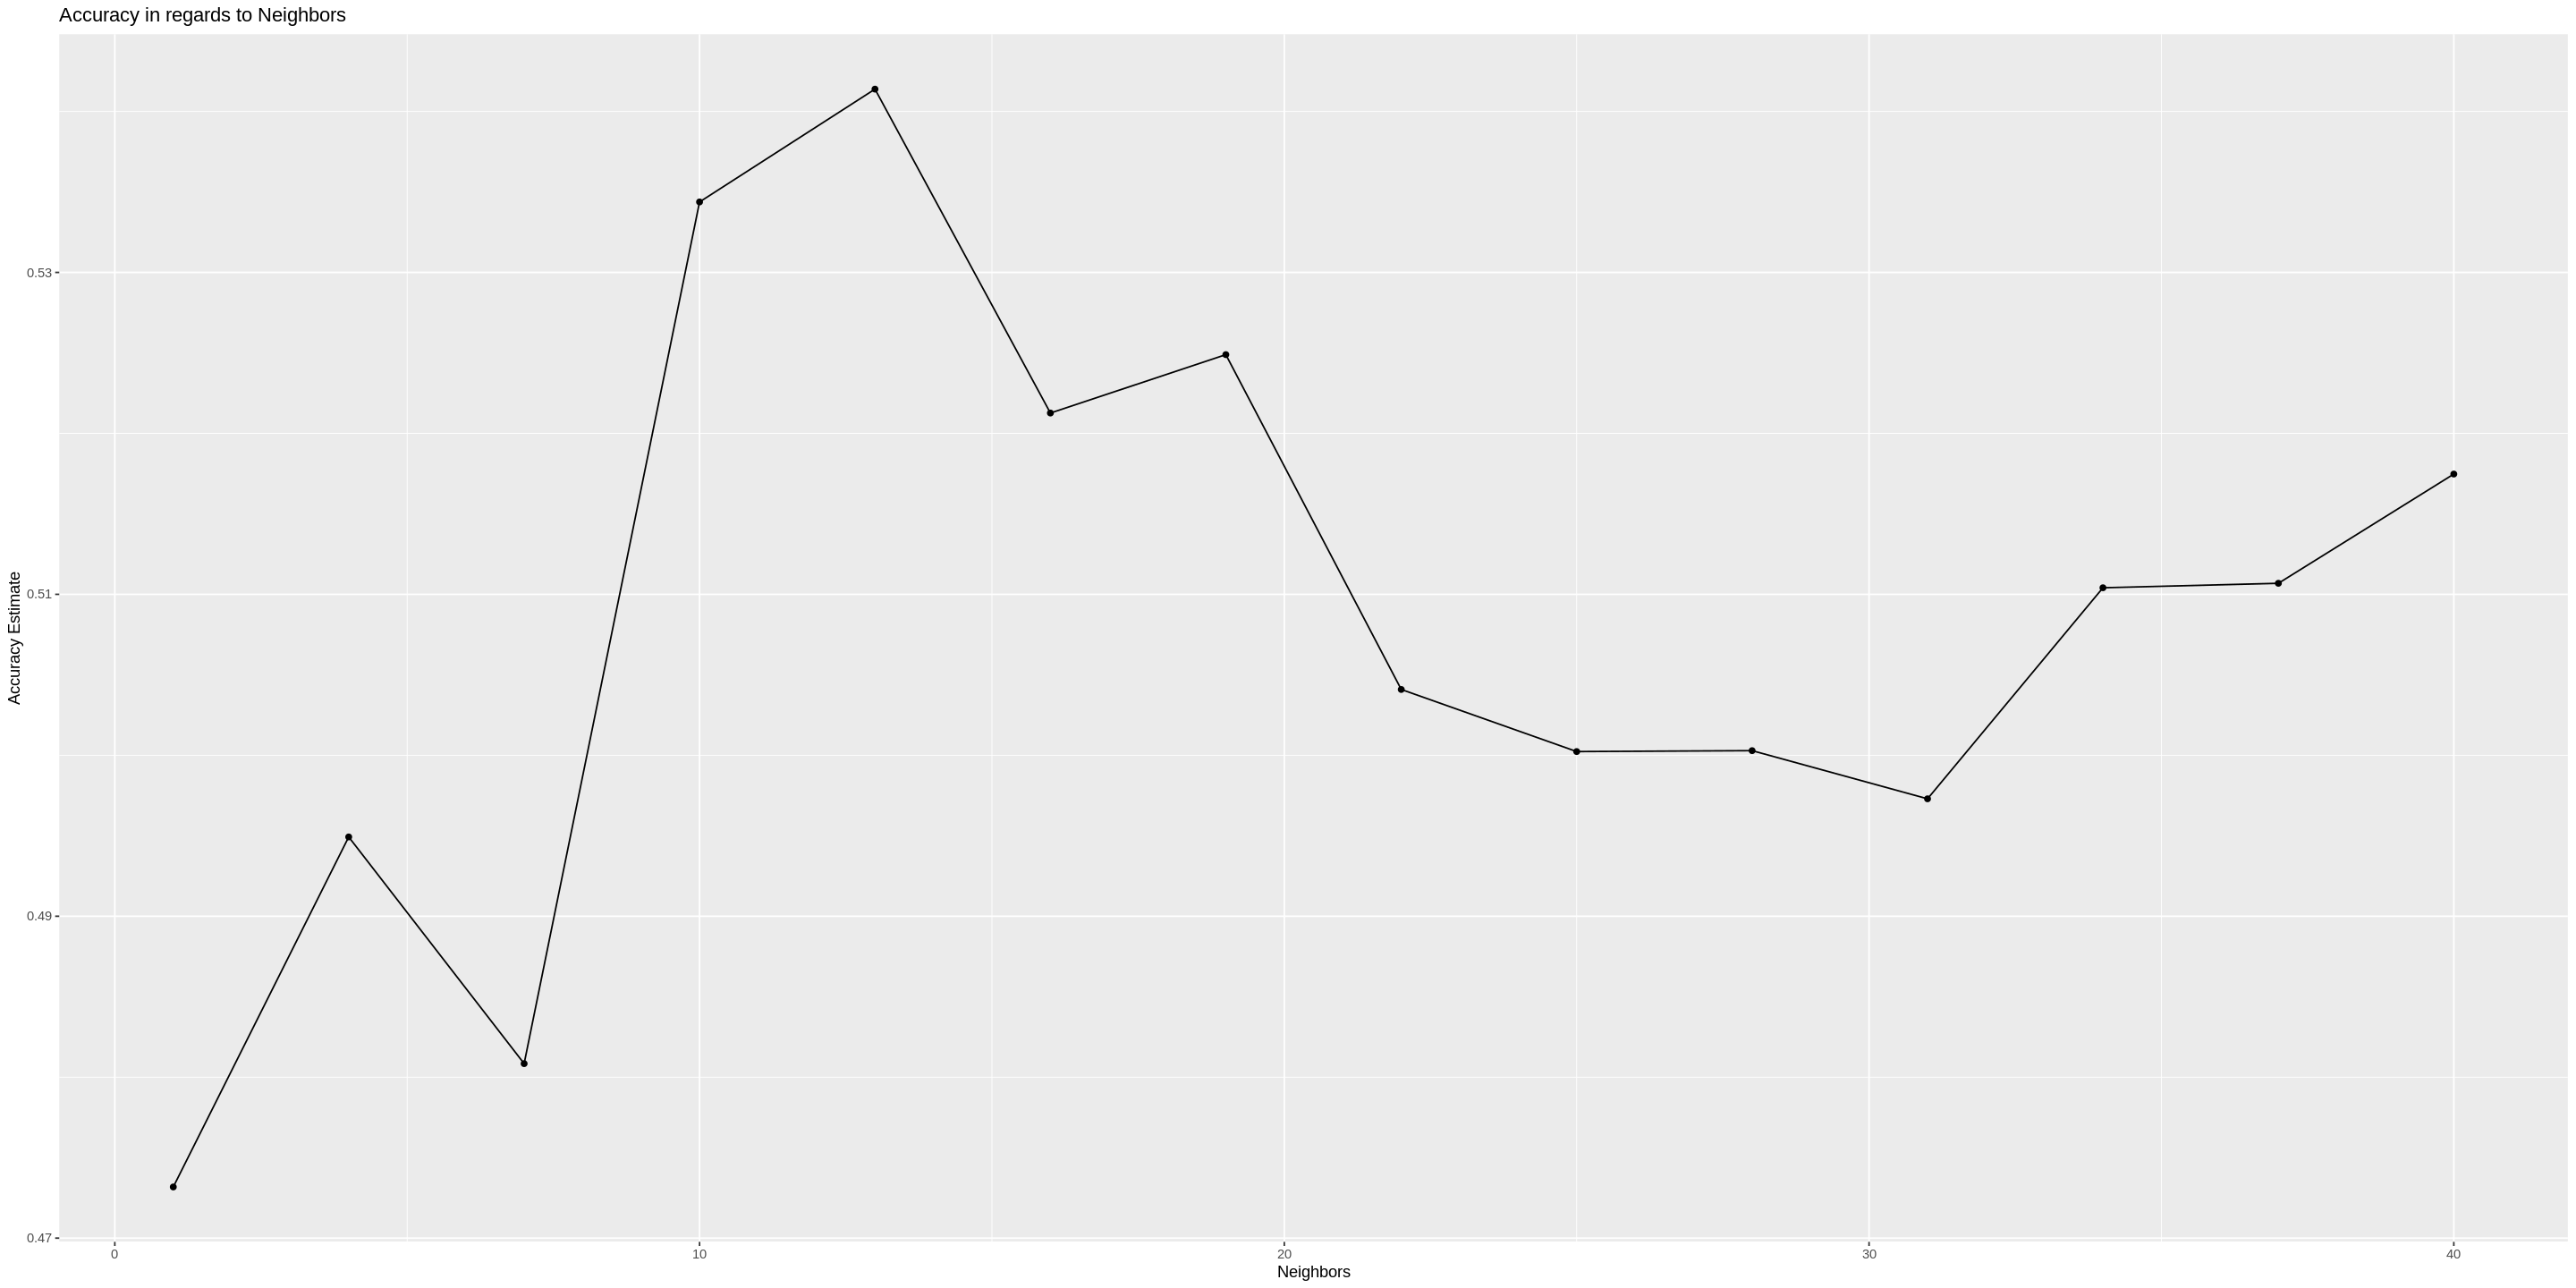

In [55]:
# shows accuracy vs. k-value: 
#shows optimal range for k that gives highest accuracy 


accuracy_vs_k_value<- accuracy_student_data%>%
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    ggtitle("Accuracy in regards to Neighbors")
accuracy_vs_k_value

Figure 3.10: Visualization of accuracy estimates across k-values. Notice that the graph peaks at k=13, indicating we get the highest accuracy estimate with k=13 neighbors

This graph was created in order to give a visual representation of the relationship between the number of neighbors and the prediction accuracy. As we can see from the graph, the highest accuracy is seen when it is approximately equal to 10-15. 



In [56]:
# so above, we have validated what k gives us the best accuracy, now let us predict it using this:                          
set.seed(1234)
knn_student_data_2<- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>%
    set_engine("kknn")%>%
    set_mode("classification")
student_knn_fit_2 <- workflow()%>%
    add_recipe(recipe_student_data)%>%
    add_model(knn_student_data_2)%>%
    fit(data = student_data_train)

Now that we have trained our model and have found the optimal k value, it is time to test it out on the test data. This cell implements similar functions to the above cells, however the main distinction is that we are specifying our k value to be 13, and instead of the training data, we use the testing data. 


In [62]:
set.seed(1234)
#test predictions: 
student_test_predictions<- predict(student_knn_fit_2, student_data_test)%>%
    bind_cols(student_data_test)


#evaluate accuracy:

accuracy_test_predictions<- student_test_predictions%>%
    metrics(truth = G3, estimate = .pred_class)%>%
    filter(.metric == "accuracy")%>%
    select(.estimate)%>%
    pull()
accuracy_test_predictions


[1] 0.4226804

The functions created in this cell were implemented in order to identify our prediction accuracy on our test data, which as shown, yields around 42 %. 


Now let's create some visualizations that will better help us discuss what we have found later in the discussion section.

In [63]:
print("Confusion Matrix")

confusion_matrix <- student_test_predictions %>%
    conf_mat(truth = G3, estimate = .pred_class)
confusion_matrix


[1] "Confusion Matrix"


          Truth
Prediction  A  B  C  D
         A  1  4  3  1
         B 19 40 18  6
         C  0  4  0  0
         D  0  0  1  0

Figure 3.11: Confusion matrix showing us a table of predicted and true labels.

In [64]:
result_percent <- student_test_predictions %>% 
    group_by(.pred_class, G3) %>%
    summarise(count = n()) %>%
    group_by(.pred_class) %>%
    mutate(percent = count/sum(count))
# result_percent

# result_percent %>%
#     group_by(.pred_class) %>%
#     summarise(sum(percent))

result_percent_2 <- student_test_predictions %>% 
    group_by(.pred_class, G3) %>%
    summarise(count = n()) %>%
    group_by(G3) %>%
    mutate(percent = count/sum(count))
# result_percent_2

# result_percent_2 %>%
#     group_by(G3) %>%
#     summarise(sum(percent))

#THIS CODE IS NEEDED FOR THE PLOTS BELOW

`summarise()` regrouping output by '.pred_class' (override with `.groups` argument)

`summarise()` regrouping output by '.pred_class' (override with `.groups` argument)



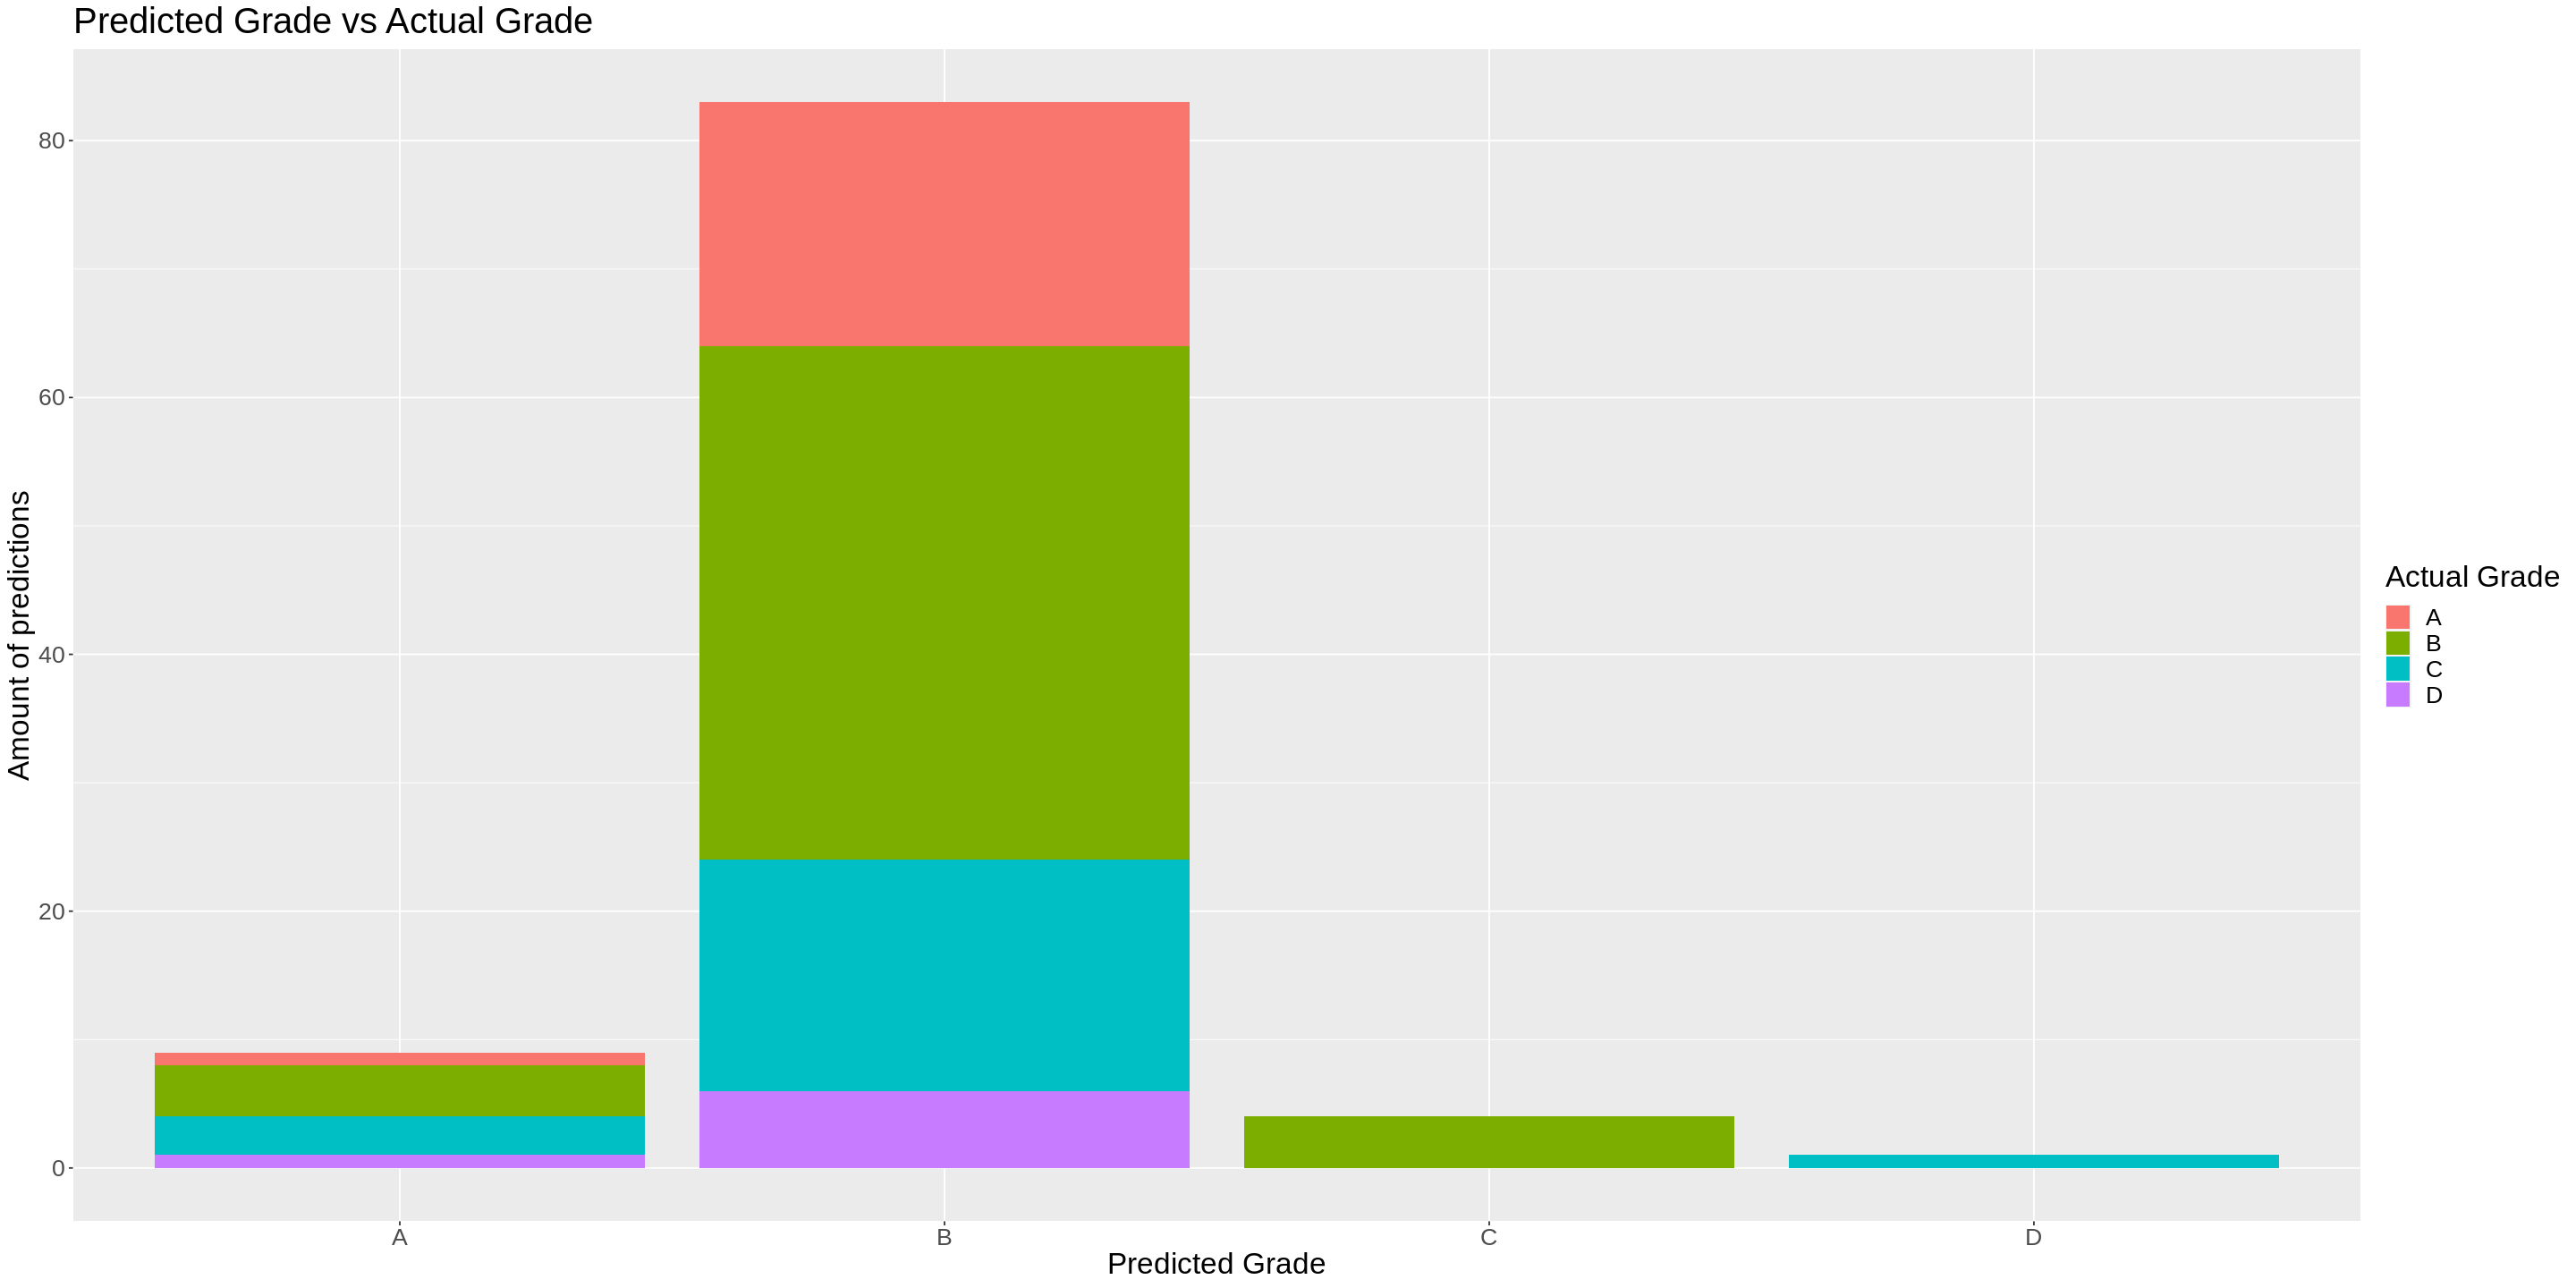

In [65]:
ggplot(student_test_predictions, aes(x = .pred_class, fill = G3)) + 
    geom_bar() +
    xlab("Predicted Grade") + 
    ylab("Amount of predictions") + 
    labs(fill = "Actual Grade") +
    ggtitle("Predicted Grade vs Actual Grade") +
    theme(text = element_text(size = 20))

Figure 4: Distribution of predicted grades compared to what the actual grade was

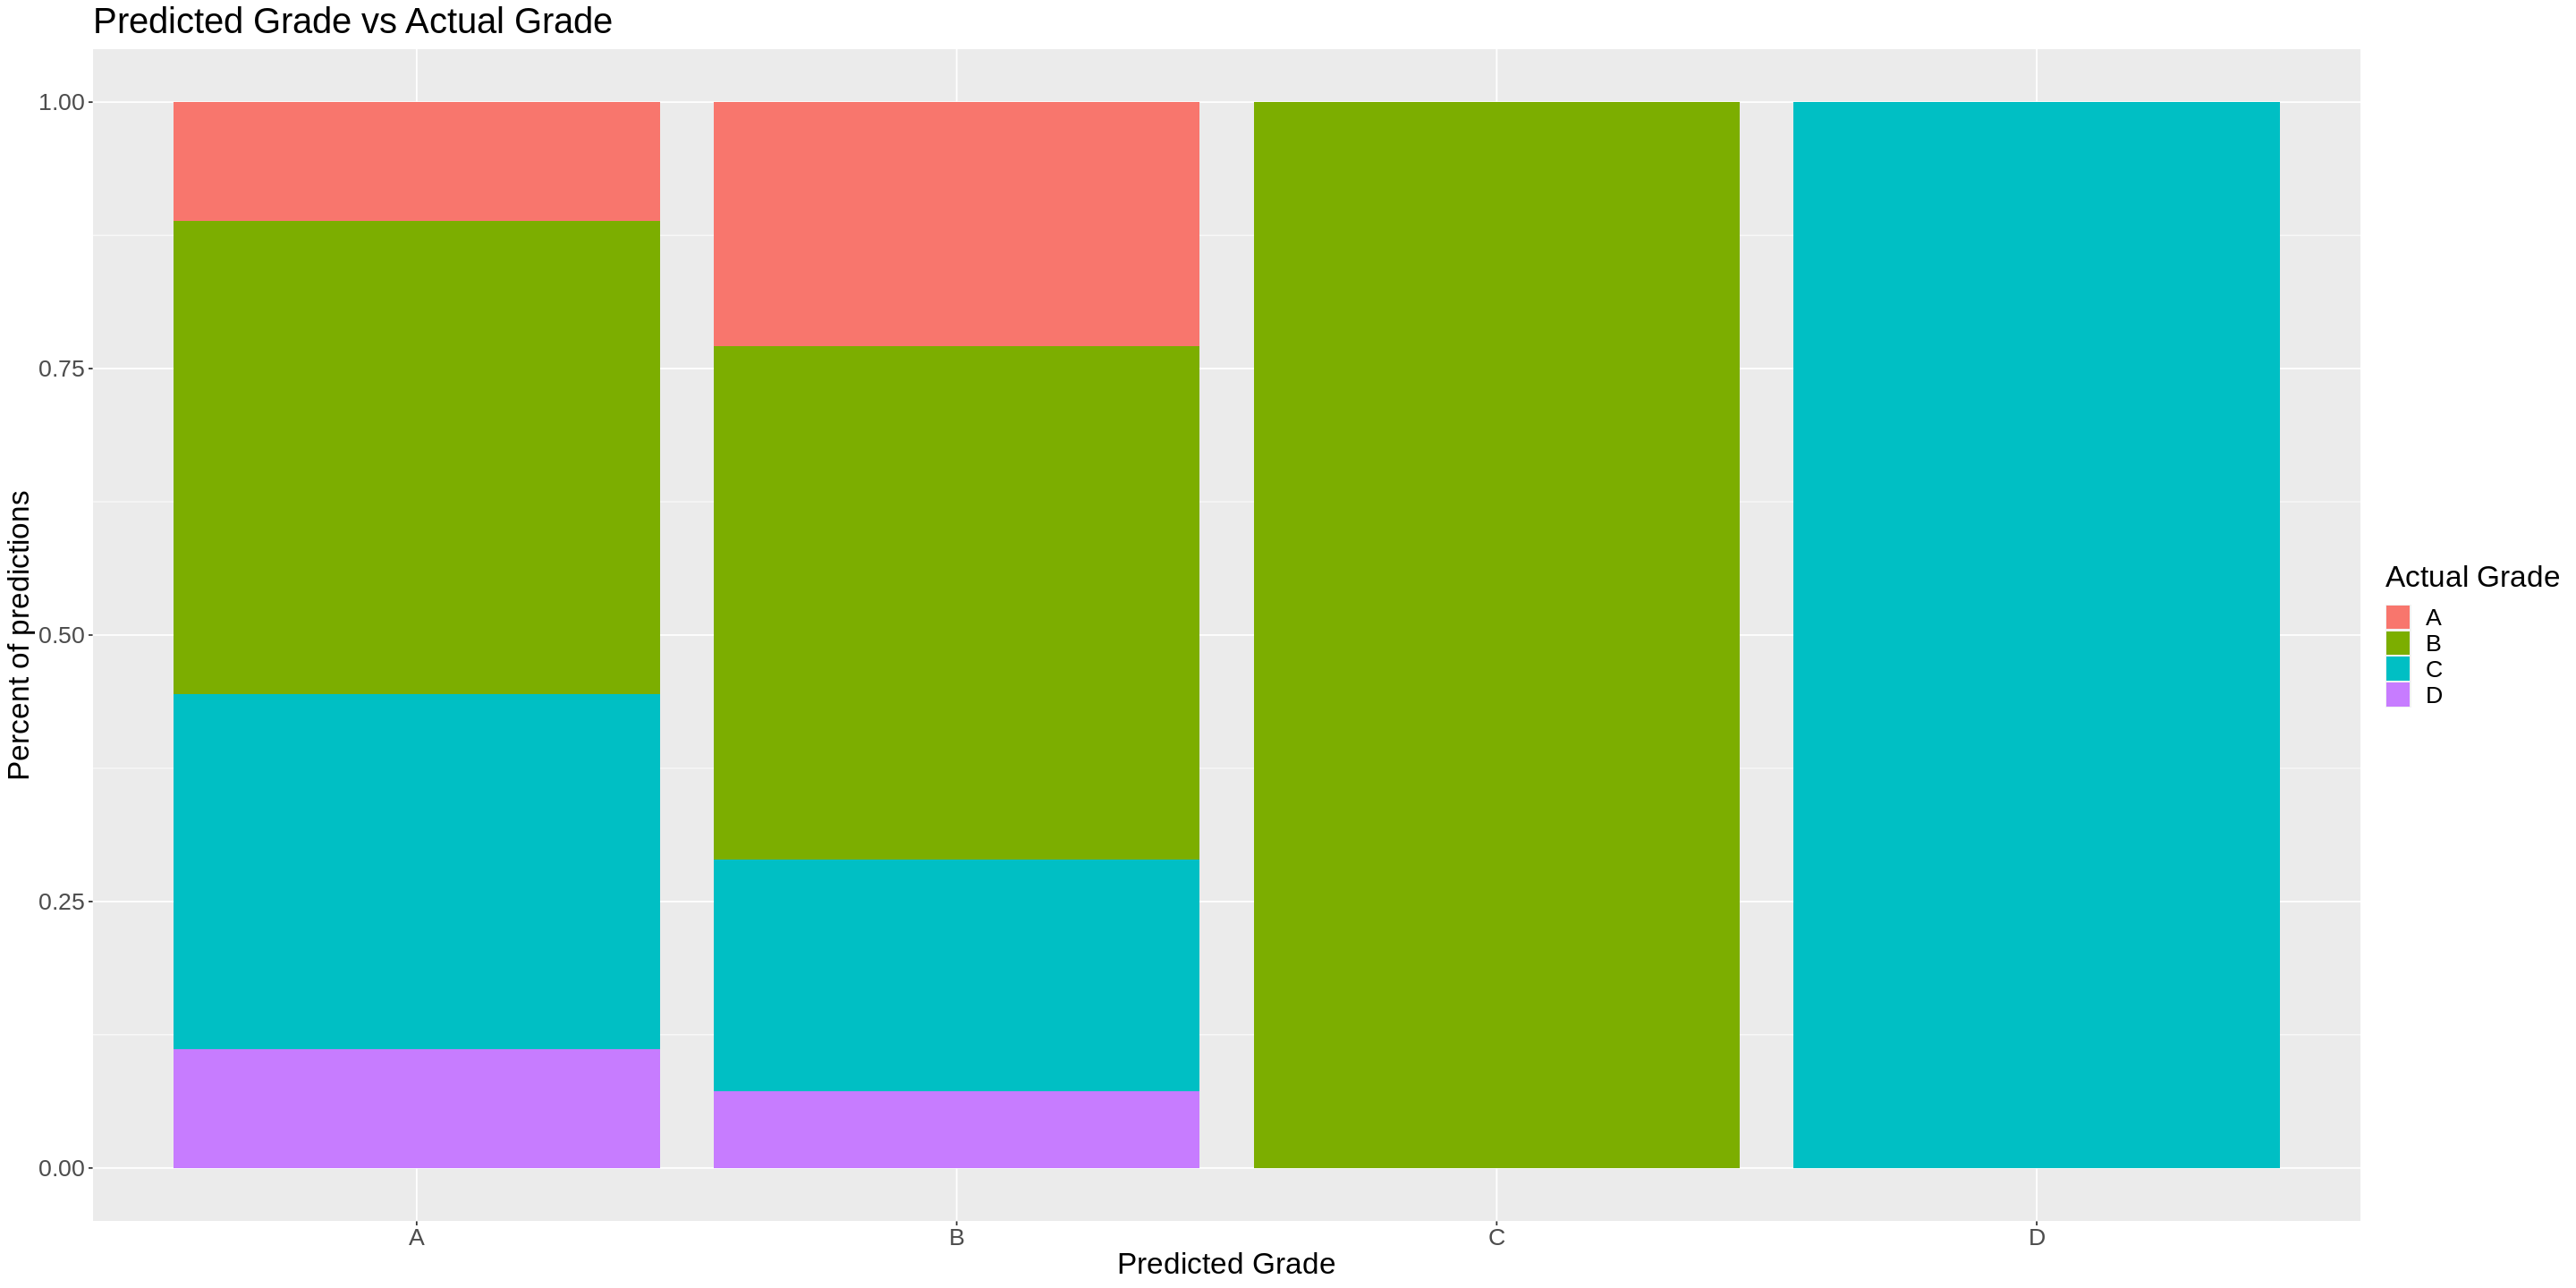

In [66]:
ggplot(result_percent, aes(x = .pred_class, y = percent, fill = G3)) +
    geom_col() +
    xlab("Predicted Grade") + 
    ylab("Percent of predictions") + 
    labs(fill = "Actual Grade") +
    ggtitle("Predicted Grade vs Actual Grade") +
    theme(text = element_text(size = 20))

Figure 4.1: Percent of Predicted Grades compared to Actual Grades

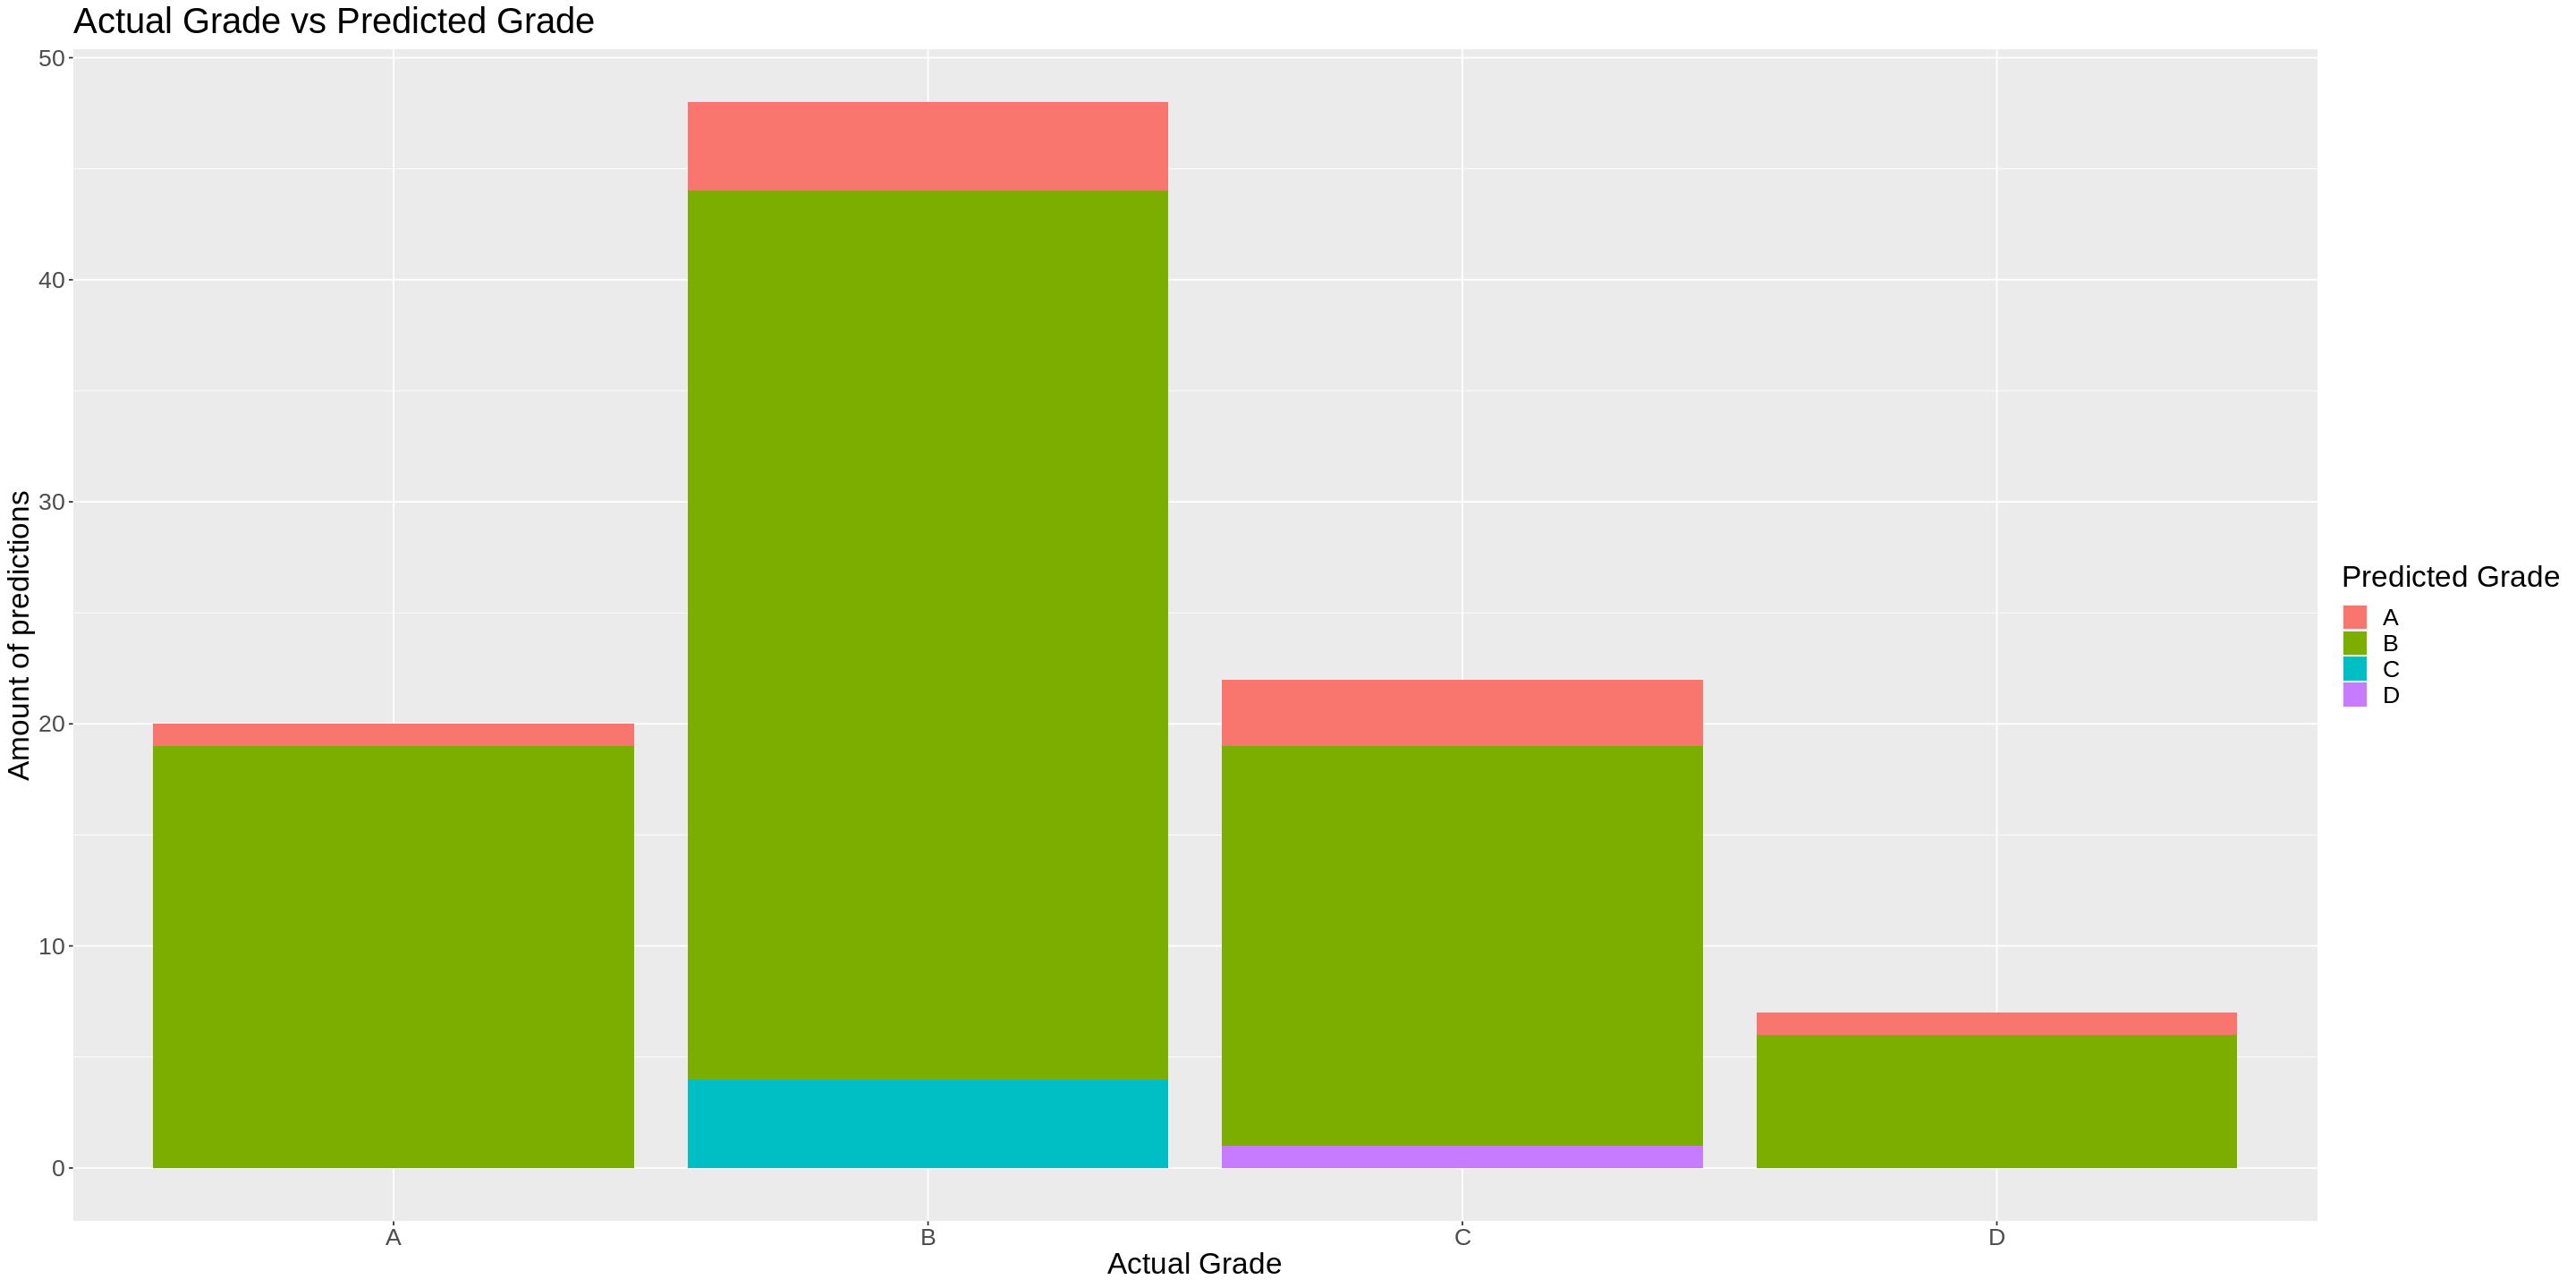

In [67]:
ggplot(student_test_predictions, aes(x = G3, fill = .pred_class)) + 
    geom_bar() +
    xlab("Actual Grade") + 
    ylab("Amount of predictions") + 
    labs(fill = "Predicted Grade") +
    ggtitle("Actual Grade vs Predicted Grade") +
    theme(text = element_text(size = 20))

Figure 4.2: Distribution of actual grades compared to what the predicted grade was

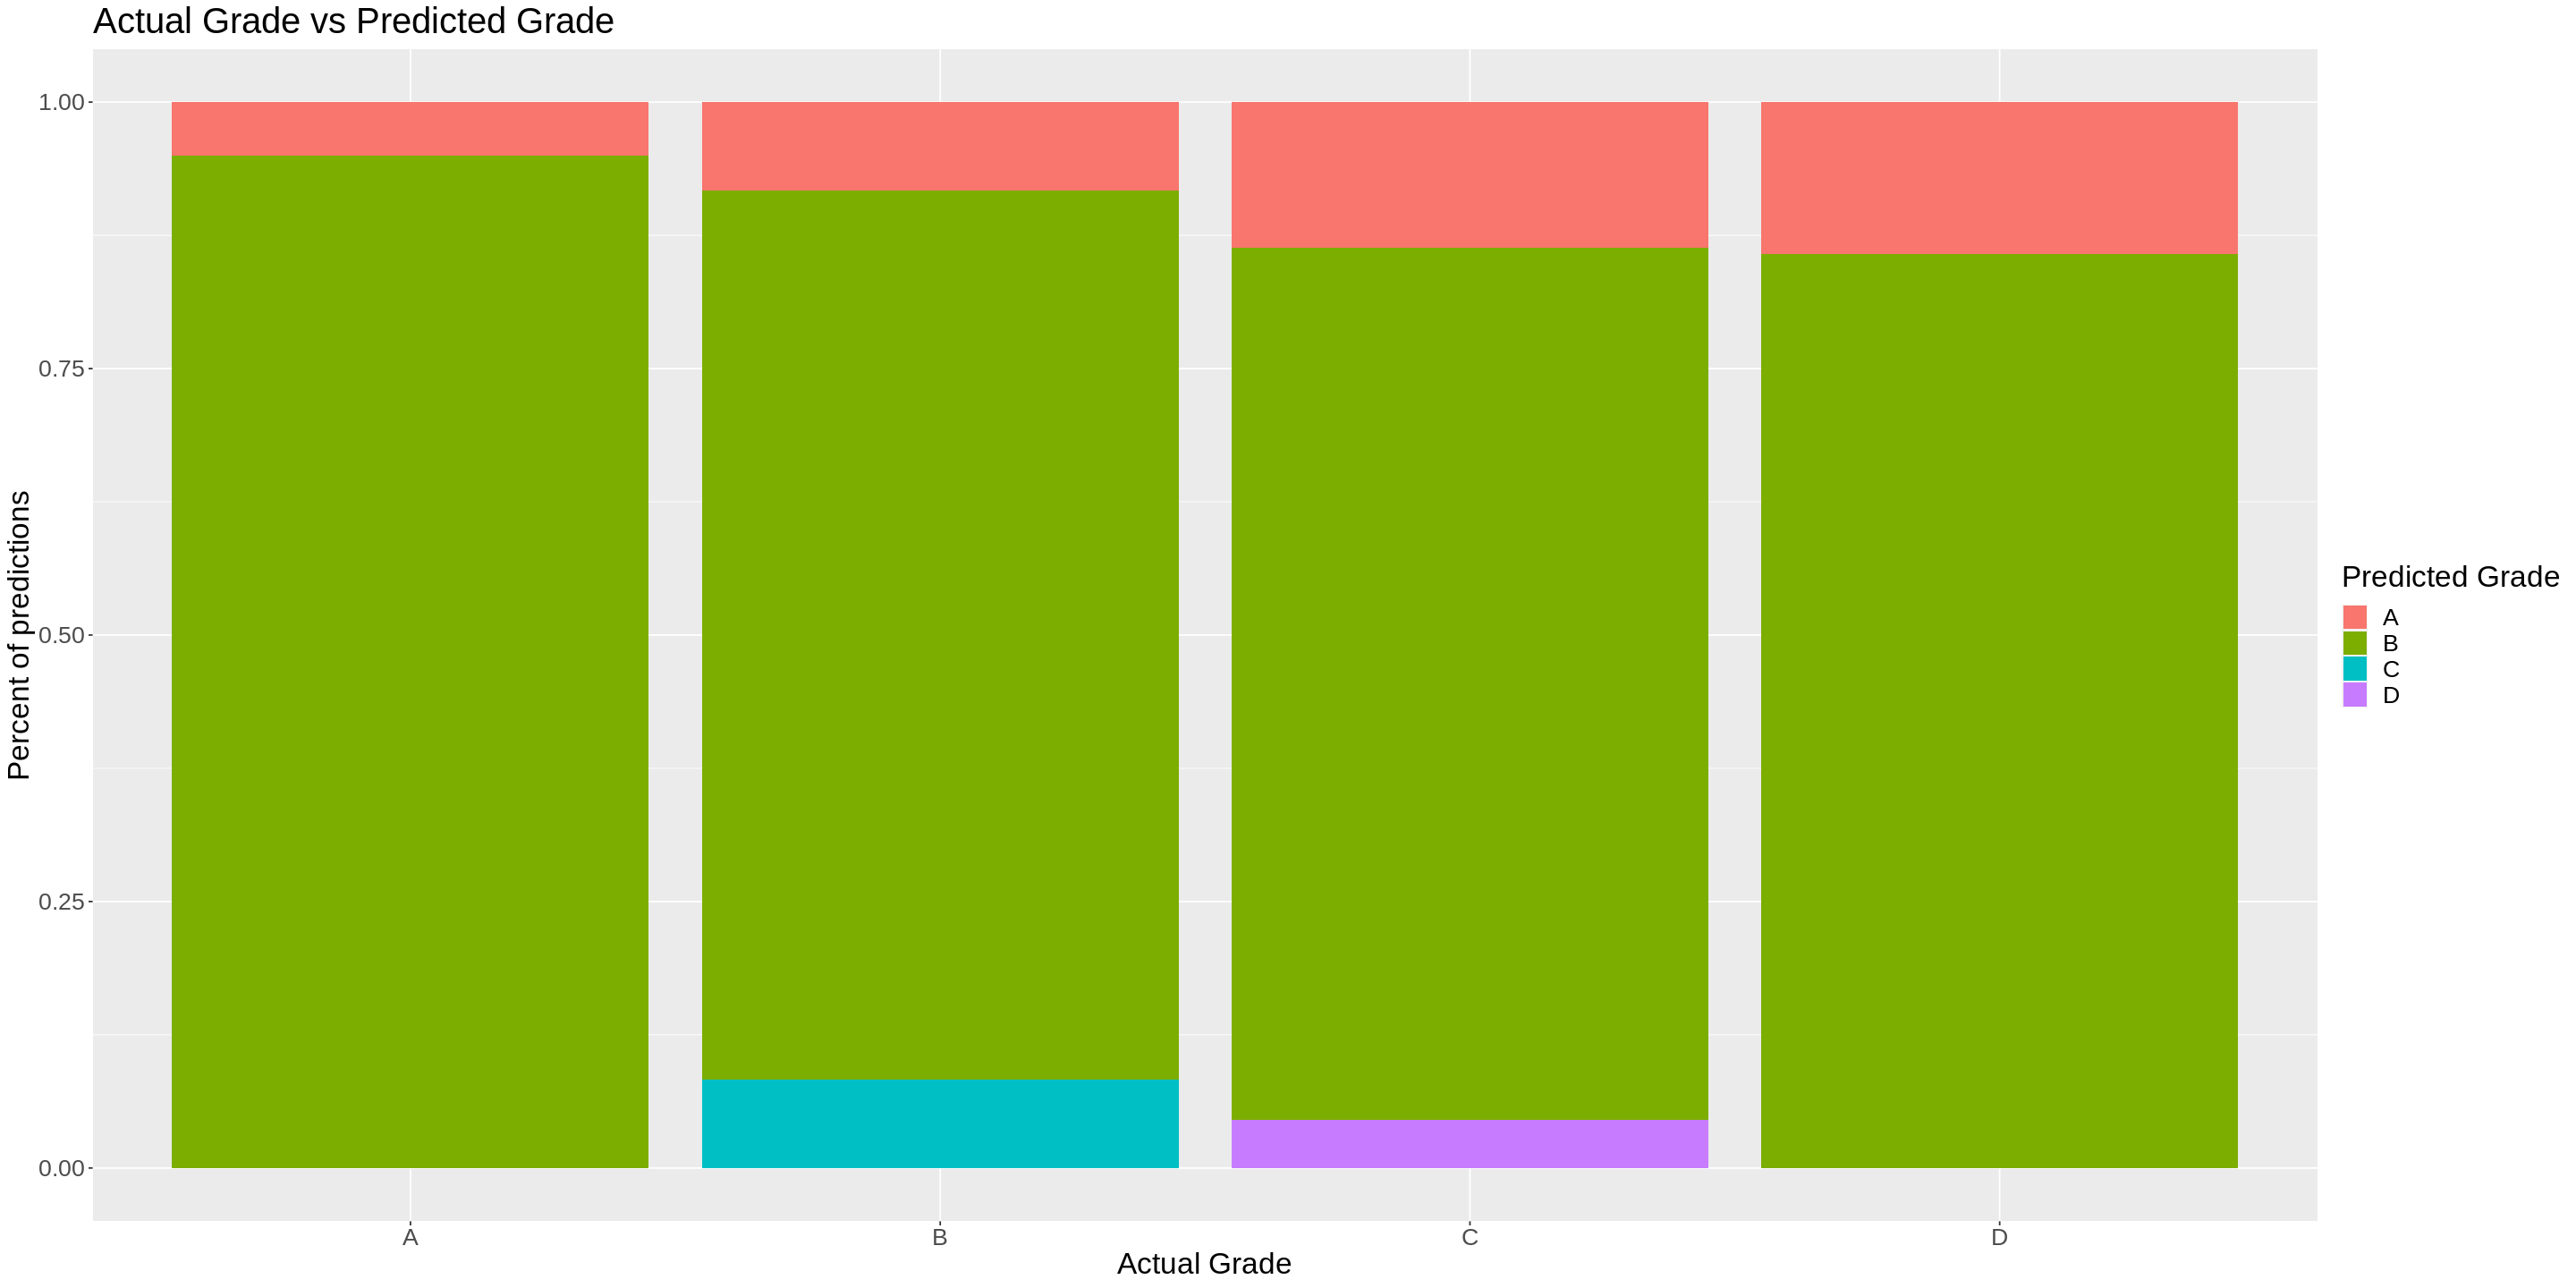

In [68]:
ggplot(result_percent_2, aes(x = G3, y = percent, fill = .pred_class)) +
    geom_col() +
    xlab("Actual Grade") + 
    ylab("Percent of predictions") + 
    labs(fill = "Predicted Grade") +
    ggtitle("Actual Grade vs Predicted Grade") +
    theme(text = element_text(size = 20))

Figure 4.3: Percent of Actual Grades compared to Predicted Grades

### Process and Justification of Selecting Our Predictors

In [69]:
set.seed(2000)
# validating choice of predictors: with 2 predictor variables
student_data_3 <- student_data_clean %>%
    select(studytime, absences, G3)

student_data_new_3 <- mutate(student_data_3, G3 = case_when(G3 %in% (0:4) ~ "D",
                                                       G3 %in% (5:9) ~ "C",
                                                       G3 %in% (10:14) ~ "B",
                                                       G3 %in% (15:20) ~ "A"),
                        G3 = as.factor(G3))

#split data (choosing )
student_data_split_3<-initial_split(student_data_new_3, prop = 0.75, strata=G3)
student_data_train_3 <- training(student_data_split_3)
student_data_test_3<- testing(student_data_split_3)

# split into 5 sub section to preform cross validation
student_data_vfold_3<-vfold_cv(student_data_train_3, v = 5, strata = G3)

knn_student_data_3<- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")
knn_student_data_3

#make recipe

stand_student_data_3<-recipe(G3 ~ studytime + absences, data = student_data_train_3)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())


k_vals_3 <- tibble(neighbors = seq(from = 1, to = 40, by = 3))
#fit model
student_model_fit_3 <- workflow()%>%
    add_recipe(stand_student_data_3)%>%
    add_model(knn_student_data_3)%>%
    tune_grid(resamples = student_data_vfold_3, grid = k_vals)%>%
    collect_metrics()

accuracy_student_data_3<- student_model_fit_3%>%
    filter(.metric == "accuracy")%>%
    arrange(desc(mean))



best_k_3<- accuracy_student_data_3%>%
    slice(1:10)
best_k_3

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
34,accuracy,multiclass,0.4640582,5,0.02444806,Model12
37,accuracy,multiclass,0.4640582,5,0.02444806,Model13
31,accuracy,multiclass,0.4573272,5,0.02574056,Model11
40,accuracy,multiclass,0.4538809,5,0.02227595,Model14
28,accuracy,multiclass,0.4437601,5,0.01965691,Model10
25,accuracy,multiclass,0.4404249,5,0.02614789,Model09
7,accuracy,multiclass,0.4373139,5,0.02699115,Model03
22,accuracy,multiclass,0.4339240,5,0.02601646,Model08
13,accuracy,multiclass,0.4302554,5,0.02803291,Model05


In [70]:
set.seed(2000)
# validating choice of predictors: with 3 predictor variables
student_data_4 <- student_data_clean %>%
    select(studytime, failures, absences, G3)

student_data_new_4 <- mutate(student_data_4, G3 = case_when(G3 %in% (0:4) ~ "D",
                                                       G3 %in% (5:9) ~ "C",
                                                       G3 %in% (10:14) ~ "B",
                                                       G3 %in% (15:20) ~ "A"),
                        G3 = as.factor(G3))

#split data (choosing )
student_data_split_4<-initial_split(student_data_new_4, prop = 0.75, strata=G3)
student_data_train_4 <- training(student_data_split_4)
student_data_test_4<- testing(student_data_split_4)

# split into 5 sub section to preform cross validation
student_data_vfold_4<-vfold_cv(student_data_train_4, v = 5, strata = G3)

knn_student_data_4<- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")


#make recipe

stand_student_data_4<-recipe(G3 ~ studytime + failures + absences, data = student_data_train_4)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())


k_vals_4 <- tibble(neighbors = seq(from = 1, to = 40, by = 3))

#fit model
student_model_fit_4 <- workflow()%>%
    add_recipe(stand_student_data_4)%>%
    add_model(knn_student_data_4)%>%
    tune_grid(resamples = student_data_vfold_4, grid = k_vals)%>%
    collect_metrics()

accuracy_student_data_4<- student_model_fit_4%>%
    filter(.metric == "accuracy")%>%
    arrange(desc(mean))



best_k_4<- accuracy_student_data_4%>%
    slice(1:10)
best_k_4


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
34,accuracy,multiclass,0.5248395,5,0.03242578,Model12
37,accuracy,multiclass,0.5150034,5,0.03836534,Model13
28,accuracy,multiclass,0.5083271,5,0.04055561,Model10
40,accuracy,multiclass,0.5042001,5,0.02522328,Model14
31,accuracy,multiclass,0.4982141,5,0.03818936,Model11
25,accuracy,multiclass,0.4952123,5,0.04508442,Model09
22,accuracy,multiclass,0.4950543,5,0.04375085,Model08
13,accuracy,multiclass,0.4846373,5,0.04272088,Model05
19,accuracy,multiclass,0.4813077,5,0.03010740,Model07


In [71]:
set.seed(2000)
# validating choice of predictors: with 4 predictor variables
student_data_5 <- student_data_clean %>%
    select(studytime, failures, health, absences, G3)

student_data_new_5 <- mutate(student_data_5, G3 = case_when(G3 %in% (0:4) ~ "D",
                                                       G3 %in% (5:9) ~ "C",
                                                       G3 %in% (10:14) ~ "B",
                                                       G3 %in% (15:20) ~ "A"),
                        G3 = as.factor(G3))

#split data (choosing )
student_data_split_5<-initial_split(student_data_new_5, prop = 0.75, strata=G3)
student_data_train_5 <- training(student_data_split_5)
student_data_test_5<- testing(student_data_split_5)

# split into 5 sub section to preform cross validation
student_data_vfold_5<-vfold_cv(student_data_train_5, v = 5, strata = G3)

knn_student_data_5<- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")


#make recipe

stand_student_data_5<-recipe(G3 ~ studytime + failures +health + absences, data = student_data_train_5)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())


k_vals_5 <- tibble(neighbors = seq(from = 1, to = 40, by = 3))
#fit model
student_model_fit_5 <- workflow()%>%
    add_recipe(stand_student_data_5)%>%
    add_model(knn_student_data_5)%>%
    tune_grid(resamples = student_data_vfold_5, grid = k_vals)%>%
    collect_metrics()

accuracy_student_data_5<- student_model_fit_5%>%
    filter(.metric == "accuracy")%>%
    arrange(desc(mean))



best_k_5<- accuracy_student_data_5%>%
    slice(1:10)
best_k_5


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,multiclass,0.5413890,5,0.03320808,Model05
10,accuracy,multiclass,0.5343793,5,0.02979570,Model04
19,accuracy,multiclass,0.5248922,5,0.04089264,Model07
16,accuracy,multiclass,0.5212645,5,0.03659190,Model06
40,accuracy,multiclass,0.5174729,5,0.02062400,Model14
37,accuracy,multiclass,0.5106854,5,0.02148063,Model13
34,accuracy,multiclass,0.5104085,5,0.01526880,Model12
22,accuracy,multiclass,0.5040890,5,0.02586266,Model08
28,accuracy,multiclass,0.5002877,5,0.01249289,Model10


These cells show our final justification for choosing the two additional predictor variables used, classes failed and the students health. As we had already decided and solidified our decision to use study time and absences, we wanted to test our model using the specified variables. We found that study time and absences yielded a relatively low prediction accuracy, and very high neighbor value, and thus in order to increase accuracy, and decrease the number of neighbors, we tested, through trial and error a numerous other predictor variables in conjunction with the specified two. We have left out the majority of test cases, but as you can see from the above code, with the addition of student failures we were able to increase prediction accuracy, which we were content about, but still had a high k value which was problematic. To combat this, we tried adding a fourth predictor variable, keeping in mind that increasing dimensionality is problematic (Pestov, 2013), and fortunately, we identified student health as the final variable, which not only yielded the highest prediction accuracy, but minimized the number of neighbors to a suitable range. Thus, this is how we were able to choose, with confidence, our predictors. 


## Discussion

Let’s begin by summarizing very briefly what we’ve done above:
- Loaded the data, and cleaned/wrangled it to allow for further preliminary exploration.
- Explained and justified our process of eliminating/filtering down the variables until we were left with 4 predictor variables. 
- Backed up the relevance of our 4 predictor variables with sources.
- Summarized the data with a table and reflected on it.
- Visualized the data with several graphs and reflected on each one.
- Performed the data analysis, narrating each step with markdown cells to communicate what is being done.
- Visualized the findings, providing markdown cells briefly describing the contents of each graph.

**So what did we find?** Well, we determined using cross-validation that a k-value of 11 gave us the best estimate of the accuracy of our classifier. And from building our model using k=11, we predicted it on our testing set and found that the accuracy of our model on predicting the testing set was approximately 43%. We then printed a confusion matrix (Figure 3.11) displaying a table of predicted labels and true labels, helping us examine the number of labels that were correctly predicted, as well as labels that were not correct. We can see that our model was most accurate in predicting the label grade B from the confusion matrix. What’s also insightful to point out is that our model predicted a grade label of B most commonly for each of the other true labels. This means that for observations with true grades of A, C, and D, our model most commonly predicted a grade of B when looking at observations with a true grade of A, a true grade of C and a true grade of D. This would also imply that the majority of the observations were classified by our model with a predictive grade/label of B. Figures 4.2 and 4.3 provide a visualization of this, and again we can see for each of the actual grades, the majority of the observations were classified with a predicted grade of B for all 4 of the true grades. Looking at Figures 4 and 4.1, we can visualize this the other way around from the first two graphs by looking at the predicted grades and seeing the actual grade distribution across each predicted grade. Here, it is clear that when looking at observations with predicted grades A and B, the majority of them are classified with a true grade of B. What’s interesting as well is that our model failed to accurately predict any observation with a true grade of C and D. Observations with a true grade of D were predicted across grades of A and B, while those with a true grade of C were predicted across grades of A, B and D.
Looking at the figures relating to the summary of the data set and relevant visualizations, let's first take a look at Figure 3.2, which visualizes the distribution of grades based on study time. Here we can see that the proportion/percentage of students with a grade of A increases as study time increases, and the percentage of students with the lower grades C and D decreases study time increases. The percentage of students with a grade of B generally stays similar while we go up in study time . For Figure 3.4, we can see that the percentage of students with a final grade of A are highest for those with a high health level, and decrease slightly as we go down health levels. The percentage of students with a lower grade of C increases slightly as we move down health levels. There seems to be no observable pattern in the distribution of students with grades B and D as we move down the health levels. Looking at Figure 3.6, we can see that the percentage of students with a true grade of A and B decreases as the number of class failures increase, with a final grade of A making up 0% of students who have failed 3 classes. Examining Figure 3.8, we can see from the distribution of grades across absences, there seems to be slightly more absences as we move down grades. Observations with a final grade of D seem to have the highest percentage of students with 0 absences. 

**Is this what we expected to find?** 
Citing our expected outcomes, we hypothesized/believed that students with a limited number of absences would achieve higher academic success. This is not true from examining Figure 3.8, as students with the lowest grade of D had the highest percentage of students with 0 absences. However, this could be due to the fact that students with a grade of D make up the smallest portion of students’ grades (Table 2). As such, a small size would disproportionately affect the percentage of student absences, and in this case because there are not many students with a grade of D, one student would make up a significant percentage of the population with a grade of D. We also expected that students in good health, more study time and less number of failed classes would have higher academic success. The visualizations in our preliminary data analysis support this, as the findings explained in the previous paragraph would naturally deduce this outcome. As for the accuracy of our classifier, we expected to build a model that would be at least 70% accurate in predicting the grade labels on the testing set. Our best accuracy was only around 50%, we believe it could be a result of the fact that the majority of students had an average grade, “B”. Alternatively, this could also imply that with only the predictors we’re using, similar values could result in various different grades, suggesting that there is something outside of these predictors that will determine a student’s success. Perhaps factors such as testing anxiety have been associated with inhibition of academic performance (England et al., 2019).

**What impact could such findings have?**
With what our best accuracy is suggesting, there is a chance that there is something outside of our predictors that is having a big effect on student success. This is strange, as we chose our predictors partially based on what studies believe would have the most effect on success. However, perhaps there is some other major factor affecting student success that isn’t commonly thought of, and it would benefit education greatly to determine what it is and as a result improve our understanding of educational needs of students.
 
**What future questions could this lead to?**
- Which factor or combination of factors results in higher student success?
- Knowing if certain combinations of factors are prevalent in students that do well could help educators figure out what to encourage in students?
- What factors outside of those that we explored could lead to even more accurate predictions of student success?


##Note: We acknowledge that we went over the word count, but we were given verbal confirmation that we could, and that we wouldn't get deducted marks. As such, we have proceeded with writing this report with this acknowledgement in mind.

